## Imports and Data Loading

### Imports

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error
import seaborn as sns
from IPython.display import display, HTML
from sklearn.metrics import roc_auc_score, roc_curve, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE  # Recursive Feature Elimination for feature selection
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import ScalarFormatter
from sklearn.neural_network import MLPClassifier
import shap
import pickle

### Loading 2013-2014 NHANES Data

In [148]:
# Read the CSV files into dfs
df1 = pd.read_csv('questionnaire.csv')
df2 = pd.read_csv('demographic.csv')
df3 = pd.read_csv('diet.csv')
df4 = pd.read_csv('examination.csv')

### Loading 2015-2016

In [149]:
df_15_16 = pd.read_csv('merged_data.csv')
# Set numbers between 0 and 0.0001 to 0
df_15_16 = df_15_16.applymap(lambda x: 0 if isinstance(x, (int, float)) and 0 < x < 0.0001 else x)

C:\Users\larry\AppData\Local\Temp\ipykernel_28172\3328956275.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_15_16 = df_15_16.applymap(lambda x: 0 if isinstance(x, (int, float)) and 0 < x < 0.0001 else x)


### Loading 2011-12 

In [150]:
df_11_12 = pd.read_csv('merged_2011_2012.csv')

df_11_12 = df_11_12.applymap(lambda x: 0 if isinstance(x, (int, float)) and 0 < x < 0.0001 else x)

C:\Users\larry\AppData\Local\Temp\ipykernel_28172\3453741107.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_11_12 = df_11_12.applymap(lambda x: 0 if isinstance(x, (int, float)) and 0 < x < 0.0001 else x)


### Loading 2017-18 

In [151]:
df_17_18 = pd.read_csv('merged_2017_2018.csv')

df_17_18 = df_17_18.applymap(lambda x: 0 if isinstance(x, (int, float)) and 0 < x < 0.0001 else x)

C:\Users\larry\AppData\Local\Temp\ipykernel_28172\1951393457.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_17_18 = df_17_18.applymap(lambda x: 0 if isinstance(x, (int, float)) and 0 < x < 0.0001 else x)


In [152]:
df_09_10 = pd.read_csv('merged_2009_2010.csv')

df_09_10 = df_09_10.applymap(lambda x: 0 if isinstance(x, (int, float)) and 0 < x < 0.0001 else x)

df_09_10['ALQ151'] = df_09_10['ALQ150']  # Rename ALQ150 to ALQ151

C:\Users\larry\AppData\Local\Temp\ipykernel_28172\3672275837.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_09_10 = df_09_10.applymap(lambda x: 0 if isinstance(x, (int, float)) and 0 < x < 0.0001 else x)


### Merging Data into single DF

In [153]:
# Merge the dfs on the 'seqn' column
df = df1.merge(df2, on='SEQN').merge(df3, on='SEQN').merge(df4, on='SEQN')

print(df.shape)

df = pd.concat([df, df_15_16], ignore_index=True)

# Print the merged df
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df.shape)


(9813, 1389)
(10175, 953)
(10175, 47)
(9813, 168)
(9813, 224)
(19784, 1410)


### Choosing columns

In [154]:
columns_to_keep_17 = [
    'SEQN', 'RIAGENDR', 'RIDAGEYR', 'DMDEDUC2', 'BPXDI1', 'BPXDI2', 'BPXDI3', 'BPXSY1', 'BPXSY2', 'BPXSY3', 'BMXBMI', 'BMXHT', 'BMXWAIST', 'BMXWT', 'BPQ080',
    'DRQSPREP', 'DIQ010','PAQ650', 'PAQ665', 'ALQ111','ALQ121','ALQ151', 'ALQ130', 'SMQ020', 'SMQ040', 'DBQ700', 'HSD010', 'SMQ050Q', 'SMQ050U', 'SMD057', 'SMD641', 'SMD650', 'SMD030',
    'MCQ160F'
]

df_17_18=df_17_18[columns_to_keep_17]

df_17_18=df_17_18[df_17_18['RIDAGEYR']>=18]


In [155]:
# List of columns to keep
columns_to_keep = [
    'SEQN', 'RIAGENDR', 'RIDAGEYR', 'DMDEDUC2', 'BPXDI1', 'BPXDI2', 'BPXDI3', 'BPXSY1', 'BPXSY2', 'BPXSY3', 'BMXBMI', 'BMXHT', 'BMXWAIST', 'BMXWT', 'BPQ080',
    'DRQSPREP', 'DIQ010','PAQ650', 'PAQ665', 'ALQ101','ALQ151', 'ALQ120Q', 'ALQ120U', 'ALQ130', 'SMQ020', 'SMQ040', 'DBQ700', 'HSD010', 'SMQ050Q', 'SMQ050U', 'SMD055', 'SMD057', 'SMD641', 'SMD650', 'SMD030',
    'MCQ160F'
]

# Drop all columns except for the specified ones
df = df[columns_to_keep]

df_testing = df_11_12[columns_to_keep]

# Drop all rows where RIDAGEYR is less than 18
df = df[df['RIDAGEYR'] >= 18]

df_testing = df_testing[df_testing['RIDAGEYR'] >= 18]

df.head()

,SEQN,RIAGENDR,RIDAGEYR,DMDEDUC2,BPXDI1,BPXDI2,BPXDI3,BPXSY1,BPXSY2,BPXSY3,...,DBQ700,HSD010,SMQ050Q,SMQ050U,SMD055,SMD057,SMD641,SMD650,SMD030,MCQ160F
0,73557.0,1.0,69.0,3.0,72.0,76.0,74.0,122.0,114.0,102.0,...,2.0,2.0,3.0,4.0,66.0,2.0,NaN,NaN,17.0,1.0
1,73558.0,1.0,54.0,3.0,62.0,80.0,42.0,156.0,160.0,156.0,...,3.0,4.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,2.0
2,73559.0,1.0,72.0,4.0,90.0,76.0,80.0,140.0,140.0,146.0,...,3.0,3.0,40.0,4.0,26.0,3.0,NaN,NaN,20.0,2.0
4,73561.0,2.0,73.0,5.0,86.0,88.0,86.0,136.0,134.0,142.0,...,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
5,73562.0,1.0,56.0,4.0,84.0,82.0,80.0,160.0,158.0,154.0,...,5.0,5.0,16.0,4.0,40.0,5.0,NaN,NaN,18.0,2.0


### Filling nulls that can be imputed

In [156]:
# Filling Nulls Due to Skip Questions
df.loc[df['ALQ101'] == 2, ['ALQ120U', 'ALQ120Q', 'ALQ130']] = df.loc[df['ALQ101'] == 2, ['ALQ120U', 'ALQ120Q', 'ALQ130']].fillna(0)
df.loc[df['ALQ101'] == 2, ['ALQ151']] = df.loc[df['ALQ101'] == 2, ['ALQ151']].fillna(2)
df.loc[df['ALQ120Q'] == 0, ['ALQ130']] = df.loc[df['ALQ120Q'] == 0, ['ALQ130']].fillna(0)
df.loc[df['SMQ020'] != 1, ['SMQ040']] = df.loc[df['SMQ020'] != 1, ['SMQ040']].fillna(3)
df.loc[df['ALQ120Q'] <= 3, ['ALQ130']] = df.loc[df['ALQ120Q'] <= 3, ['ALQ130']].fillna(0)

# Filling Nulls Due to Skip Questions
df_testing.loc[df_testing['ALQ101'] == 2, ['ALQ120U', 'ALQ120Q', 'ALQ130']] = df_testing.loc[df_testing['ALQ101'] == 2, ['ALQ120U', 'ALQ120Q', 'ALQ130']].fillna(0)
df_testing.loc[df_testing['ALQ101'] == 2, ['ALQ151']] = df_testing.loc[df_testing['ALQ101'] == 2, ['ALQ151']].fillna(2)
df_testing.loc[df_testing['ALQ120Q'] == 0, ['ALQ130']] = df_testing.loc[df_testing['ALQ120Q'] == 0, ['ALQ130']].fillna(0)
df_testing.loc[df_testing['SMQ020'] != 1, ['SMQ040']] = df_testing.loc[df_testing['SMQ020'] != 1, ['SMQ040']].fillna(3)
df_testing.loc[df_testing['ALQ120Q'] <= 3, ['ALQ130']] = df_testing.loc[df_testing['ALQ120Q'] <= 3, ['ALQ130']].fillna(0)

df_17_18.loc[df_17_18['ALQ111'] == 2, ['ALQ121', 'ALQ130']] = df_17_18.loc[df_17_18['ALQ111'] == 2, ['ALQ121', 'ALQ130']].fillna(0)
df_17_18.loc[df_17_18['ALQ111'] == 2, ['ALQ151']] = df_17_18.loc[df_17_18['ALQ111'] == 2, ['ALQ151']].fillna(2)
df_17_18.loc[df_17_18['ALQ121'] == 0, ['ALQ130']] = df_17_18.loc[df_17_18['ALQ121'] == 0, ['ALQ130']].fillna(0)

df_17_18.loc[df_17_18['SMQ020'] != 1, ['SMQ040']] = df_17_18.loc[df_17_18['SMQ020'] != 1, ['SMQ040']].fillna(3)


### Improving Column Names

In [157]:
# Rename the columns as specified
new_column_names = {
    'SEQN': 'ID',
    'RIAGENDR': 'Gender',
    'RIDAGEYR': 'Age',
    'BPXDI1': 'DiasBP1',
    'BPXDI2': 'DiasBP2',
    'BPXDI3': 'DiasBP3',
    'BPXSY1': 'SysBP1',
    'BPXSY2': 'SysBP2',
    'BPXSY3': 'SysBP3',
    'BMXBMI': 'BMI',
    'BMXHT': 'Height',
    'BMXWAIST': 'Waist',
    'BMXWT': 'Weight',
    'BPQ080': 'Cholesterol',
    'DRQSPREP': 'SaltFreq',
    'PAQ650': 'VigActivity',
    'PAQ665': 'ModActivity',
    'ALQ151': 'AlcConsumpMoreThan4/5MostDays',
    'ALQ120Q': 'AlcConsumpFreq',
    'ALQ120U' : 'UnitAlc',
    'ALQ130': 'AlcConsumpAmtPerDrinkDay',
    'SMQ020': '100Cigs',
    'DBQ700': 'OvrDietHealth',
    'HSD010': 'GenHealth',
    'SMQ040': 'Smoker',
    'DMDEDUC2': 'EducationLvl',
    'DIQ010' : 'Diabetes',
    'SMD030' : 'AgeStartedSmokingReg',
    'SMQ050Q': 'TimeQuit',
    'SMD055': 'AgeLastSmokedReg',
    'SMD057': 'WhenSmokedCigs/Day',
    'SMD641': 'DaysSmokedInLast30',
    'SMD650': 'AvgCigs/DayInLast30',
    'MCQ160F': 'Stroke'
}

df.rename(columns=new_column_names, inplace=True)

df_testing.rename(columns=new_column_names, inplace=True)

df_17_18.rename(columns=new_column_names, inplace=True)

# Find columns that are in df but not in df_17_18
columns_in_df_not_in_df_17_18 = set(df.columns) - set(df_17_18.columns)

# Print the columns
print("Columns in df but not in df_17_18:")
print(columns_in_df_not_in_df_17_18)

# Find columns that are in df but not in df_17_18
columns_in_df_17_18_not_in_df = set(df_17_18.columns) - set(df.columns)

# Print the columns
print("Columns in df_17_18 but not in df:")
print(columns_in_df_17_18_not_in_df)


Columns in df but not in df_17_18:
{'AlcConsumpFreq', 'AgeLastSmokedReg', 'ALQ101', 'UnitAlc'}
Columns in df_17_18 but not in df:
{'ALQ121', 'ALQ111'}


## Feature Descriptions

### Cholesterol
- **Question:** Do you suffer from high cholesterol?

### Diet
- **Question:** Are you on a diet?

### Salt Frequency
- **Question:** How often do you add salt to your food?
  - 1 = Never
  - 2 = Rarely
  - 3 = Occasionally
  - 4 = Very Often

### Asthma
- **Question:** Have you ever been told you have asthma? (Refer to MCQ035 to check if you still have it)

### Stroke
- **Question:** Have you ever had a stroke?

### Vigorous Activity
- **Question:** Do you engage in any vigorous activity?

### Moderate Activity
- **Question:** Do you engage in any moderate activity?

### Over the Last 2 Weeks...
- **FeelPoorEating:** Have you been bothered by poor eating or appetite?
- **FeelTired:** Have you felt tired?
- **SleepTroubles:** Have you struggled to fall asleep, stay asleep, or slept too much?
- **FeelDepressed:** Have you felt depressed?

### Alcohol Consumption
- **AlcConsumpMoreThan4/5MostDays:** Have you ever consumed more than 4/5 drinks on most days?
- **AlcConsumpFreq:** How many days have you consumed alcohol in the past year?
- **AlcConsumpAmtPerDrinkDay:** On days you drank in the last year, on average, how many drinks did you have?

### Smoking
- **SMD030:** Age started smoking regularly (skip if < 100 cigs)
  - 7-64
  - 0 = Never regular
  - 80 = 80+
- **Smoker:** Do you currently smoke?
  - 1 = Every day
  - 2 = Some days
  - 3 = Never
- **SMQ050Q:** How long since you quit? (Skip if smoker = 1/2)
- **SMD055:** Age last smoked regularly (skip if still smokes/< 100 cigs)
- **SMD057:** When did you smoke, how many? (Skip if still smokes/< 100 cigs)
  - 1-90
  - 95+
- **SMD641:** Days smoked in the past 30 days (skip if not a current smoker)
- **SMD650:** Average number of cigarettes per day in the past 30 days (skip if not a current smoker)

### Overall Diet Health
- **Question:** How would you rate the health of your diet?
  - 1 = Excellent
  - 2 = Very good
  - 3 = Good
  - 4 = Fair
  - 5 = Poor

### General Health
- **Question:** How would you rate your general health condition?
  - 1 = Excellent
  - 2 = Very good
  - 3 = Good
  - 4 = Fair
  - 5 = Poor

### Sleep During Work Days
- **Question:** How much sleep do you get during work days?
  - 2-11 hours
  - 12 = 12+ hours

### Education Level
- **Question:** What is the highest level of school that you have completed?
  - 1 = Less than grade 9
  - 2 = Less than matriculated
  - 3 = High school graduate
  - 4 = Some college degree
  - 5 = College graduate or higher

### Diabetes
- **Question:** Has a doctor ever told you that you have diabetes?
  - 1 = Yes
  - 2 = No
  - 3 = Borderline

### Prediabetic
- **Question:** Has a doctor ever told you that you are prediabetic?


# Data Exploration

In [158]:
df.isnull().sum()

ID                                  0
Gender                              0
Age                                 0
EducationLvl                      609
DiasBP1                          1089
DiasBP2                           762
DiasBP3                           787
SysBP1                           1089
SysBP2                            762
SysBP3                            787
BMI                               407
Height                            386
Waist                             961
Weight                            390
Cholesterol                         0
SaltFreq                         1211
Diabetes                            0
VigActivity                         0
ModActivity                         0
ALQ101                           1287
AlcConsumpMoreThan4/5MostDays    1292
AlcConsumpFreq                   1289
UnitAlc                          2335
AlcConsumpAmtPerDrinkDay         1289
100Cigs                             0
Smoker                              0
OvrDietHealt

In [159]:
def plot_bivariate(col, hue):
    if df[col].nunique() > 5:
        plt.figure(figsize=(20, 10))
        rot = 90
    else:
        plt.figure(figsize=(10, 7))
        rot = 0

    def percentage(ax):
        heights = [[p.get_height() for p in bars] for bars in ax.containers]  # Get the counts of each bar, make arrays when more than one in group
        min_length = min(len(group) for group in heights)  # Find the minimum length of the groups
        for bars in ax.containers:
            for i, p in enumerate(bars):
                if i >= min_length:
                    continue  # Skip if index is out of range for any group
                total = sum(group[i] for group in heights)  # Sum total of each group
                percentage = (100 * p.get_height() / total)  # Calculate % to annotate
                ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() * 0.5, 0.8 * p.get_height()), 
                            ha='center', va='bottom', rotation=0)
                if percentage > 25.0:
                    percentage = f'{percentage:.1f}%'
                    ax.annotate(percentage, (p.get_x() + p.get_width() * 0.5, 0.25 * p.get_height()), 
                                ha='center', va='center', rotation=rot)

    plot = sns.countplot(x=df[col], hue=df[hue], palette='pastel')
    percentage(plot)
    plt.xticks(rotation=rot)
    plt.show()

In [160]:
def calculate_average(df, features, new_feature_name):
    # Check and select the relevant columns from the df
    relevant_columns = df[features].replace({0: np.nan})  # Replace zeros with NaN to exclude from mean calculation
    
    # Calculate the mean across the specified columns, ignoring NaN values
    df[new_feature_name] = relevant_columns.mean(axis=1, skipna=True)

## Creating BP features

In [161]:
diasBP_features = ['DiasBP1', 'DiasBP2', 'DiasBP3']
sysBP_features = ['SysBP1', 'SysBP2', 'SysBP3']

calculate_average(df, diasBP_features, 'AvgDiasBP')
calculate_average(df, sysBP_features, 'AvgSysBP')

calculate_average(df_testing, diasBP_features, 'AvgDiasBP')
calculate_average(df_testing, sysBP_features, 'AvgSysBP')

calculate_average(df_17_18, diasBP_features, 'AvgDiasBP')
calculate_average(df_17_18, sysBP_features, 'AvgSysBP')

In [162]:
# Drop rows where AvgSysBP is null
df = df.dropna(subset=['AvgSysBP'])
df_testing = df_testing.dropna(subset=['AvgSysBP'])
df_17_18 = df_17_18.dropna(subset=['AvgSysBP'])

## Creating a Hypertension Variable

In [163]:
conditions = [
    df['AvgSysBP'] < 130,
    (df['AvgSysBP'] >= 130)
]
values = [0, 1]

# Use np.select to handle NaNs and assign the appropriate category
df['HypertensionLvl'] = np.select(conditions, values, default=np.nan)

conditions_df_testing = [
    df_testing['AvgSysBP'] < 130,
    df_testing['AvgSysBP'] >= 130
]
df_testing['HypertensionLvl'] = np.select(conditions_df_testing, values, default=np.nan)

conditions_df_17_18 = [
    df_17_18['AvgSysBP'] < 130,
    df_17_18['AvgSysBP'] >= 130
]
df_17_18['HypertensionLvl'] = np.select(conditions_df_17_18, values, default=np.nan)

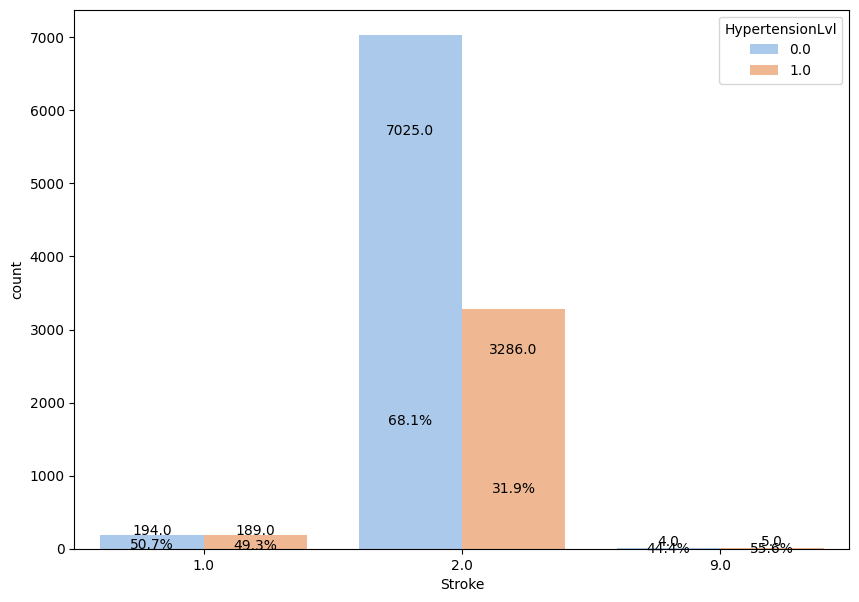

In [164]:
plot_bivariate('Stroke', 'HypertensionLvl')

## Creating Smoking Features

In [165]:
df.loc[df['TimeQuit'] == 66666, 'TimeQuit'] = 50
df_testing.loc[df_testing['TimeQuit'] == 66666, 'TimeQuit'] = 50
df_17_18.loc[df_17_18['TimeQuit'] == 66666, 'TimeQuit'] = 50

In [166]:
# Define the transformation function
def transform_time_quit(row):
    if row['SMQ050U'] == 1:
        return 0
    elif row['SMQ050U'] == 2:
        return (row['TimeQuit'] / 52)
    elif row['SMQ050U'] == 3:
        return (row['TimeQuit'] / 12)
    else:
        return row['TimeQuit']

# Apply the transformation to the TimeQuit column
df['TimeQuit'] = df.apply(transform_time_quit, axis=1)
df_testing['TimeQuit'] = df_testing.apply(transform_time_quit, axis=1)
df_17_18['TimeQuit'] = df_17_18.apply(transform_time_quit, axis=1)


In [167]:
df_17_18 = df_17_18.drop(df_17_18[df_17_18['TimeQuit'] > 100].index)

In [168]:
# Update AgeLastSmokedReg where it is null, TimeQuit is not null, and TimeQuit is smaller than 100
df.loc[(df['AgeLastSmokedReg'].isnull()) & (df['TimeQuit'].notnull()) & (df['TimeQuit'] < 100) & (df['Smoker'] == 3) & (df['100Cigs'] == 1), 'AgeLastSmokedReg'] = df['Age'] - df['TimeQuit']
df_testing.loc[(df_testing['AgeLastSmokedReg'].isnull()) & (df_testing['TimeQuit'].notnull()) & (df_testing['TimeQuit'] < 100) & (df_testing['Smoker'] == 3) & (df_testing['100Cigs'] == 1), 'AgeLastSmokedReg'] = df_testing['Age'] - df_testing['TimeQuit']

### Creating YearsSmoked Feature

In [169]:
df.loc[df['AgeStartedSmokingReg'] > 100, 'AgeStartedSmokingReg'] = np.nan

df_testing.loc[df_testing['AgeStartedSmokingReg'] > 100, 'AgeStartedSmokingReg'] = np.nan

df_17_18.loc[df_17_18['AgeStartedSmokingReg'] > 100, 'AgeStartedSmokingReg'] = np.nan

df.loc[df['TimeQuit'] > 66666, 'TimeQuit'] = np.nan

df_testing.loc[df_testing['TimeQuit'] > 66666, 'TimeQuit'] = np.nan

df_17_18.loc[df_17_18['TimeQuit'] > 66666, 'TimeQuit'] = np.nan

df.loc[df['AgeLastSmokedReg'] > 100, 'AgeLastSmokedReg'] = np.nan

df_testing.loc[df_testing['AgeLastSmokedReg'] > 100, 'AgeLastSmokedReg'] = np.nan

df = df.drop(columns=['SMQ050U'])

df_testing = df_testing.drop(columns=['SMQ050U'])

df_17_18 = df_17_18.drop(columns=['SMQ050U'])


df['yearsSmoked'] = np.where(
    df['Smoker'].isin([1, 2]),
    df['Age'] - df['AgeStartedSmokingReg'],
    df['AgeLastSmokedReg'] - df['AgeStartedSmokingReg']
)

df_testing['yearsSmoked'] = np.where(
    df_testing['Smoker'].isin([1, 2]),
    df_testing['Age'] - df_testing['AgeStartedSmokingReg'],
    df_testing['AgeLastSmokedReg'] - df_testing['AgeStartedSmokingReg']
)

df_17_18['yearsSmoked'] = np.where(
    df_17_18['Smoker'].isin([1, 2]),
    df_17_18['Age'] - df_17_18['AgeStartedSmokingReg'],
    df_17_18['Age'] - df_17_18['AgeStartedSmokingReg'] - df_17_18['TimeQuit']
)

df['yearsSmoked'] = df['yearsSmoked'].fillna(0)
df_testing['yearsSmoked'] = df_testing['yearsSmoked'].fillna(0)
df_17_18['yearsSmoked'] = df_17_18['yearsSmoked'].fillna(0)

C:\Users\larry\AppData\Local\Temp\ipykernel_28172\3170566072.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hypertension_percentage = df.groupby('yearsSmokedBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100


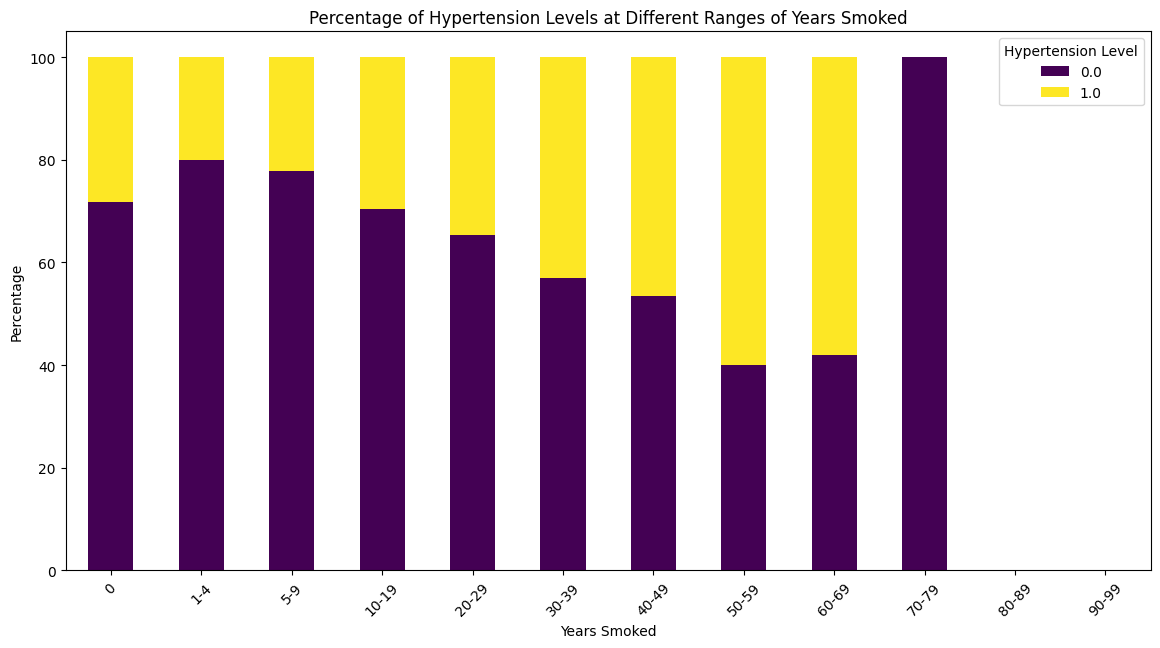

In [170]:
# Bin the yearsSmoked values
bins = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0', '1-4', '5-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
df['yearsSmokedBinned'] = pd.cut(df['yearsSmoked'], bins=bins, labels=labels, right=False)

# Calculate the percentage of hypertension levels for each bin of yearsSmoked
hypertension_percentage = df.groupby('yearsSmokedBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot the data
plt.figure(figsize=(14, 7))
hypertension_percentage.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Percentage of Hypertension Levels at Different Ranges of Years Smoked')
plt.xlabel('Years Smoked')
plt.ylabel('Percentage')
plt.legend(title='Hypertension Level')
plt.xticks(rotation=45)
plt.show()

### Creating LifetimeCigarettes Feature

In [171]:
# Define the transformation function
def calculate_lifetime_cigarettes(row):
    if row['Smoker'] == 3:
        if pd.isnull(row['WhenSmokedCigs/Day']) | (row['WhenSmokedCigs/Day'] > 100):
            return 0
        return row['yearsSmoked'] * row['WhenSmokedCigs/Day'] * 365
    elif row['Smoker'] in [1, 2]:
        if pd.isnull(row['AvgCigs/DayInLast30']) | (row['AvgCigs/DayInLast30'] > 100):
            return 0
        return row['yearsSmoked'] * row['AvgCigs/DayInLast30'] * row['DaysSmokedInLast30'] /30 * 365
    else:
        return np.nan

# Apply the transformation to create the lifetimeCigarettes feature
df['lifetimeCigarettes'] = df.apply(calculate_lifetime_cigarettes, axis=1)
df_testing['lifetimeCigarettes'] = df_testing.apply(calculate_lifetime_cigarettes, axis=1)
df_17_18['lifetimeCigarettes'] = df_17_18.apply(calculate_lifetime_cigarettes, axis=1)

# Verify the changes
print(df[['Smoker', 'yearsSmoked', 'WhenSmokedCigs/Day', 'AvgCigs/DayInLast30', 'DaysSmokedInLast30', 'lifetimeCigarettes']].head(20))

    Smoker  yearsSmoked  WhenSmokedCigs/Day  AvgCigs/DayInLast30  \
0      3.0    49.000000                 2.0                  NaN   
1      2.0    54.000000                 NaN                  1.0   
2      3.0     6.000000                 3.0                  NaN   
4      3.0     0.000000                 NaN                  NaN   
5      3.0    22.000000                 5.0                  NaN   
7      3.0     0.000000                 NaN                  NaN   
8      1.0    23.000000                 NaN                  1.0   
9      1.0    44.000000                 NaN                 25.0   
10     3.0     0.000000                 NaN                  NaN   
12     3.0     0.000000                 NaN                  NaN   
15     3.0     0.000000                 NaN                  NaN   
18     3.0    21.333333                20.0                  NaN   
19     3.0     0.000000                 NaN                  NaN   
21     3.0     0.000000                 NaN     

C:\Users\larry\AppData\Local\Temp\ipykernel_28172\2307530192.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hypertension_percentage = df.groupby('lifetimeCigarettesBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100


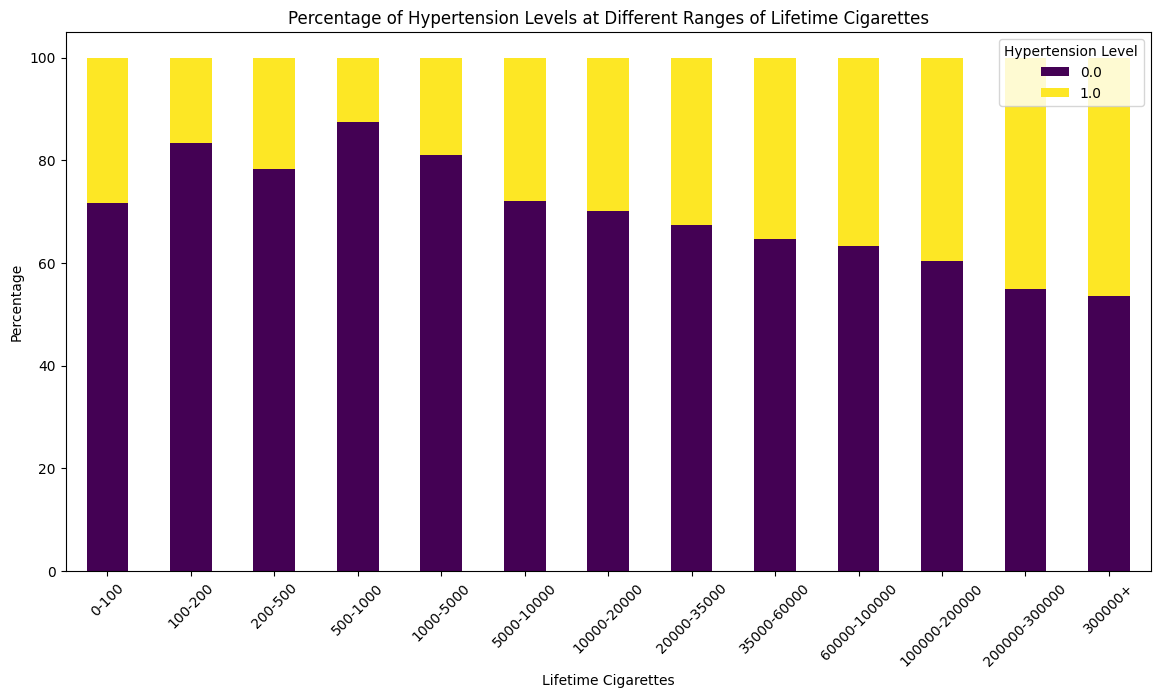

In [172]:
# Bin the lifetimeCigarettes values
bins = [0, 100, 200, 500, 1000, 5000, 10000, 20000, 35000, 60000, 100000, 200000, 300000, 1000000000000]
labels = ['0-100', '100-200', '200-500', '500-1000', '1000-5000', '5000-10000', '10000-20000', '20000-35000', '35000-60000', '60000-100000', '100000-200000', '200000-300000', '300000+']
df['lifetimeCigarettesBinned'] = pd.cut(df['lifetimeCigarettes'], bins=bins, labels=labels, right=False)

# Calculate the percentage of hypertension levels for each bin of lifetimeCigarettes
hypertension_percentage = df.groupby('lifetimeCigarettesBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot the data
plt.figure(figsize=(14, 7))
hypertension_percentage.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Percentage of Hypertension Levels at Different Ranges of Lifetime Cigarettes')
plt.xlabel('Lifetime Cigarettes')
plt.ylabel('Percentage')
plt.legend(title='Hypertension Level')
plt.xticks(rotation=45)
plt.show()

In [173]:
df = df.drop(columns=['yearsSmokedBinned', 'lifetimeCigarettesBinned', 'AgeLastSmokedReg'])

In [174]:
# Find columns that are in df but not in df_17_18
columns_in_df_not_in_df_17_18 = set(df.columns) - set(df_17_18.columns)

# Print the columns
print("Columns in df but not in df_17_18:")
print(columns_in_df_not_in_df_17_18)

# Find columns that are in df but not in df_17_18
columns_in_df_17_18_not_in_df = set(df_17_18.columns) - set(df.columns)

# Print the columns
print("Columns in df_17_18 but not in df:")
print(columns_in_df_17_18_not_in_df)

Columns in df but not in df_17_18:
{'AlcConsumpFreq', 'ALQ101', 'UnitAlc'}
Columns in df_17_18 but not in df:
{'ALQ121', 'ALQ111'}


## Alcohol Features

In [175]:
def transform_alc_consump_freq(row):
    if row['UnitAlc'] == 1:
        return (row['AlcConsumpFreq'] * 52)
    elif row['UnitAlc'] == 2:
        return (row['AlcConsumpFreq'] * 12)
    else:
        if (row['AlcConsumpFreq'] > 365):
            return np.nan
        return row['AlcConsumpFreq']
    

df['AlcConsumpFreq'] = df.apply(transform_alc_consump_freq, axis=1)
df_testing['AlcConsumpFreq'] = df_testing.apply(transform_alc_consump_freq, axis=1)

In [176]:
def set_alc_consump_freq(df):
    # Define the mapping
    mapping = {
        1: 365,
        2: 300,
        3: 182,
        4: 104,
        5: 52,
        6: 30,
        7: 12,
        8: 9,
        9: 5,
        10: 2
    }
    
    # Apply the mapping
    df['AlcConsumpFreq'] = df['ALQ121'].apply(lambda x: mapping.get(x, 0) if x != '-' else 0)

# Apply the function to df_17_18
set_alc_consump_freq(df_17_18)

In [177]:
# Set values in 'AlcConsumpAmtPerDrinkDay' to NaN where the condition is met
df.loc[df['AlcConsumpAmtPerDrinkDay'] > 25, 'AlcConsumpAmtPerDrinkDay'] = np.nan
df_testing.loc[df_testing['AlcConsumpAmtPerDrinkDay'] > 25, 'AlcConsumpAmtPerDrinkDay'] = np.nan
df_17_18.loc[df_17_18['AlcConsumpAmtPerDrinkDay'] > 25, 'AlcConsumpAmtPerDrinkDay'] = np.nan

# Calculate the new column 'AlcConsump/Yr' by multiplying the relevant columns
df['AlcConsump/Yr'] = df['AlcConsumpAmtPerDrinkDay'] * df['AlcConsumpFreq']
df_testing['AlcConsump/Yr'] = df_testing['AlcConsumpAmtPerDrinkDay'] * df_testing['AlcConsumpFreq']
df_17_18['AlcConsump/Yr'] = df_17_18['AlcConsumpAmtPerDrinkDay'] * df_17_18['AlcConsumpFreq']

In [178]:
# Find columns that are in df but not in df_17_18
columns_in_df_not_in_df_17_18 = set(df.columns) - set(df_17_18.columns)
df = df.drop(columns=columns_in_df_not_in_df_17_18)

# Print the columns
print("Columns in df but not in df_17_18:")
print(columns_in_df_not_in_df_17_18)

# Find columns that are in df but not in df_17_18
columns_in_df_17_18_not_in_df = set(df_17_18.columns) - set(df.columns)
df_17_18 = df_17_18.drop(columns=columns_in_df_17_18_not_in_df)

# Print the columns
print("Columns in df_17_18 but not in df:")
print(columns_in_df_17_18_not_in_df)

Columns in df but not in df_17_18:
{'ALQ101', 'UnitAlc'}
Columns in df_17_18 but not in df:
{'ALQ121', 'ALQ111'}


In [179]:
# df = pd.concat([df, df_17_18], ignore_index=True)

## Activity Level Features

In [180]:
#Combine vig and mod activity

df['ActivityLvl'] = df.apply(
    lambda row: 1 if row['VigActivity'] == 1 
    else (0.5 if row['VigActivity'] != 1 and row['ModActivity'] == 1 else 0), axis=1
)
df_testing['ActivityLvl'] = df_testing.apply(
    lambda row: 1 if row['VigActivity'] == 1 
    else (0.5 if row['VigActivity'] != 1 and row['ModActivity'] == 1 else 0), axis=1
)

df['WeightedActivity'] = df.apply(
    lambda row: (row['VigActivity'] * 2 if row['VigActivity'] == 1 else 0) + 
                (row['ModActivity'] if row['ModActivity'] == 1 else 0), axis=1
)

df_testing['WeightedActivity'] = df_testing.apply(
    lambda row: (row['VigActivity'] * 2 if row['VigActivity'] == 1 else 0) + 
                (row['ModActivity'] if row['ModActivity'] == 1 else 0), axis=1
)

df_17_18['ActivityLvl'] = df_17_18.apply(
    lambda row: 1 if row['VigActivity'] == 1 
    else (0.5 if row['VigActivity'] != 1 and row['ModActivity'] == 1 else 0), axis=1
)
df_17_18['WeightedActivity'] = df_17_18.apply(
    lambda row: (row['VigActivity'] * 2 if row['VigActivity'] == 1 else 0) + 
                (row['ModActivity'] if row['ModActivity'] == 1 else 0), axis=1
)

In [181]:
df = df.dropna(thresh=len(df) - 5000, axis=1)
df_testing = df_testing.dropna(thresh=len(df_testing) - 2000, axis=1)
df.isnull().sum()

ID                                 0
Gender                             0
Age                                0
EducationLvl                     580
DiasBP1                          456
DiasBP2                          129
DiasBP3                          154
SysBP1                           456
SysBP2                           129
SysBP3                           154
BMI                              118
Height                            99
Waist                            575
Weight                           102
Cholesterol                        0
SaltFreq                         788
Diabetes                           0
VigActivity                        0
ModActivity                        0
AlcConsumpMoreThan4/5MostDays    884
AlcConsumpFreq                   888
AlcConsumpAmtPerDrinkDay         887
100Cigs                            0
Smoker                             0
OvrDietHealth                      0
GenHealth                        851
Stroke                           580
A

In [182]:
def adjust_activity(row):
    if row['Age'] < 30:
        return row['WeightedActivity'] + 1
        return row[health_feature]

In [183]:
# # Adjusting 'GenHealth' using the new function
# df['WeightedActivity'] = df.apply(lambda row: adjust_activity(row), axis=1)

# df_testing['WeightedActivity'] = df.apply(lambda row: adjust_activity(row), axis=1)

# df_17_18['WeightedActivity'] = df.apply(lambda row: adjust_activity(row), axis=1)

## Health 

In [184]:
def adjust_health(row, health_feature):
    if row['Age'] < 35:
        return row[health_feature] - 0.5
    elif 60 <= row['Age'] <= 80:
        return row[health_feature] + 0.5
    elif row['Age'] >= 80:
        return row[health_feature] + 1
    else:
        return row[health_feature]

In [185]:
# Adjusting 'GenHealth' using the new function
df['GenHealth'] = df.apply(lambda row: adjust_health(row, 'GenHealth'), axis=1)
df['OvrDietHealth'] = df.apply(lambda row: adjust_health(row, 'OvrDietHealth'), axis=1)

df_testing['GenHealth'] = df.apply(lambda row: adjust_health(row, 'GenHealth'), axis=1)
df_testing['OvrDietHealth'] = df.apply(lambda row: adjust_health(row, 'OvrDietHealth'), axis=1)

df_17_18['GenHealth'] = df.apply(lambda row: adjust_health(row, 'GenHealth'), axis=1)
df_17_18['OvrDietHealth'] = df.apply(lambda row: adjust_health(row, 'OvrDietHealth'), axis=1)

## Diabetes Encoding

In [186]:
df['Diabetes'] = df['Diabetes'].replace({2: -1, 3: 2, -1: 3})

## Dropping unused features

In [187]:
df = df.drop(columns=['ID', 'DiasBP1', 'DiasBP2', 'DiasBP3', 'SysBP1', 
                      'SysBP2', 'SysBP3', 'AvgDiasBP', 'AlcConsumpMoreThan4/5MostDays', 
                       '100Cigs'])
df_testing = df_testing.drop(columns=['ID', 'DiasBP1', 'DiasBP2', 'DiasBP3', 'SysBP1',
                                  'SysBP2', 'SysBP3', 'AvgDiasBP', 'AlcConsumpMoreThan4/5MostDays',
                                  '100Cigs'])
null_values = df.isnull().sum()

In [188]:
df = df.dropna()
df_testing = df_testing.dropna()

### Removing rows from training that go against the desired trends

In [189]:
# Define the conditions
conditions = (
    (df['Age'] < 45) &
    (df['BMI'] < 26) &
    (df['Waist'] < 130) &
    (df['yearsSmoked'] < 2) &
    (df['WeightedActivity'] > 0) &
    (df['HypertensionLvl'] > 0) &
    (df['AlcConsump/Yr'] < 200)
)

# Filter the DataFrame based on the conditions
filtered_df = df[conditions]

# Drop all rows that meet the conditions
df.drop(df[conditions].index, inplace=True)

In [190]:
conditions = (
    (df['Age'] > 55) &
    (df['BMI'] > 30) &
    (df['yearsSmoked'] > 10) &
    (df['WeightedActivity'] < 1) &
    (df['HypertensionLvl'] == 0) 
)
filtered_df = df[conditions]
df.drop(df[conditions].index, inplace=True)

In [191]:
conditions = (
    (df['Age'] > 55) &
    (df['BMI'] > 30) &
    (df['AlcConsump/Yr'] > 200) &
    (df['WeightedActivity'] < 1) &
    (df['HypertensionLvl'] == 0) 
)
filtered_df = df[conditions]
df.drop(df[conditions].index, inplace=True)

In [192]:
for column in df.columns:
    print(f"Maximum value for {column}: {df[column].max()}")

Maximum value for Gender: 2.0
Maximum value for Age: 80.0
Maximum value for EducationLvl: 9.0
Maximum value for BMI: 70.1
Maximum value for Height: 202.7
Maximum value for Waist: 172.5
Maximum value for Weight: 198.9
Maximum value for Cholesterol: 9.0
Maximum value for SaltFreq: 9.0
Maximum value for Diabetes: 9.0
Maximum value for VigActivity: 9.0
Maximum value for ModActivity: 9.0
Maximum value for AlcConsumpFreq: 365.0
Maximum value for AlcConsumpAmtPerDrinkDay: 25.0
Maximum value for Smoker: 3.0
Maximum value for OvrDietHealth: 9.5
Maximum value for GenHealth: 5.5
Maximum value for Stroke: 9.0
Maximum value for AvgSysBP: 231.33333333333334
Maximum value for HypertensionLvl: 1.0
Maximum value for yearsSmoked: 71.0
Maximum value for lifetimeCigarettes: 1664400.0
Maximum value for AlcConsump/Yr: 6552.0
Maximum value for ActivityLvl: 1.0
Maximum value for WeightedActivity: 3.0


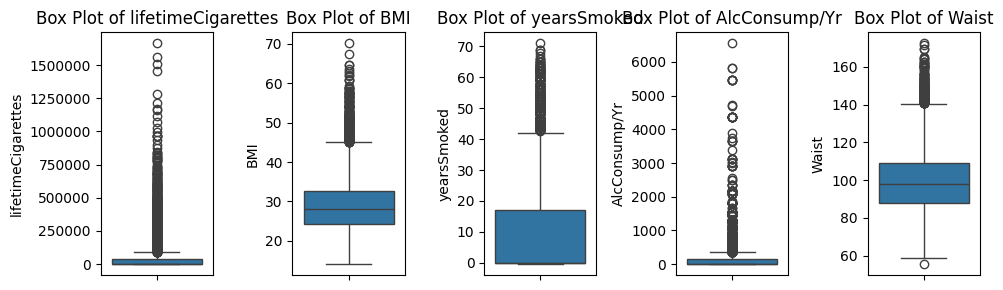

In [193]:
# Create a figure and axis
fig, ax = plt.subplots(1, 5, figsize=(10, 3))

# Create a box plot for Age
sns.boxplot(y=df['lifetimeCigarettes'], ax=ax[0])
ax[0].set_title('Box Plot of lifetimeCigarettes')

ax[0].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax[0].ticklabel_format(style='plain', axis='y')

# Create a box plot for BMI
sns.boxplot(y=df['BMI'], ax=ax[1])
ax[1].set_title('Box Plot of BMI')

sns.boxplot(y=df['yearsSmoked'], ax=ax[2])
ax[2].set_title('Box Plot of yearsSmoked')

sns.boxplot(y=df['AlcConsump/Yr'], ax=ax[3])
ax[3].set_title('Box Plot of AlcConsump/Yr')

sns.boxplot(y=df['Waist'], ax=ax[4])
ax[4].set_title('Box Plot of Waist')

# Display the plots
plt.tight_layout()
plt.show()

### Setting outlier values to a value that maintain the relationship but will not negatively affect models

In [194]:
# Cap lifetimeCigarettes at 400,000
df.loc[df['lifetimeCigarettes'] > 400000, 'lifetimeCigarettes'] = 400000
df_testing.loc[df_testing['lifetimeCigarettes'] > 400000, 'lifetimeCigarettes'] = 400000

# Cap BMI at 45
df.loc[df['BMI'] > 45, 'BMI'] = 45
df_testing.loc[df_testing['BMI'] > 45, 'BMI'] = 45

# Cap yearsSmoked at 45
df.loc[df['yearsSmoked'] > 45, 'yearsSmoked'] = 45
df_testing.loc[df_testing['yearsSmoked'] > 45, 'yearsSmoked'] = 45

# Cap AlcConsump/Yr at 900
df.loc[df['AlcConsump/Yr'] > 900, 'AlcConsump/Yr'] = 900
df_testing.loc[df_testing['AlcConsump/Yr'] > 900, 'AlcConsump/Yr'] = 900

# Cap waist at 150 and set minimum waist to 60
df.loc[df['Waist'] > 150, 'Waist'] = 150
df_testing.loc[df_testing['Waist'] > 150, 'Waist'] = 150
df.loc[df['Waist'] < 60, 'Waist'] = 60
df_testing.loc[df_testing['Waist'] < 60, 'Waist'] = 60

### Fixing any refused-to-answer fields

In [195]:
# Set Cholesterol, SaltFreq, Diabetes, OvrDietHealth to their mode when they equal 9
for column in ['Cholesterol', 'SaltFreq', 'Diabetes', 'OvrDietHealth', 'EducationLvl', 'Stroke']:
    if not df[column].dropna().empty:  # Check if column is not entirely NaN or empty
        mode_value = df[column].mode()
        if not mode_value.empty:  # Check if mode calculation returned a value
            mode_value = mode_value[0]
            df.loc[(df[column] >= 6.5) | (df[column] > 6), column] = mode_value
        else:
            print(f"No mode found for {column}.")
    else:
        print(f"Column {column} is empty or has only NaN values.")

for column in ['Cholesterol', 'SaltFreq', 'Diabetes', 'OvrDietHealth', 'EducationLvl']:
    if not df_testing[column].dropna().empty:  # Check if column is not entirely NaN or empty
        mode_value = df_testing[column].mode()
        if not mode_value.empty:  # Check if mode calculation returned a value
            mode_value = mode_value[0]
            df_testing.loc[(df[column] >= 6.5) | (df_testing[column] > 6), column] = mode_value
        else:
            print(f"No mode found for {column}.")
    else:
        print(f"Column {column} is empty or has only NaN values.")


# Set YearsSmoked and LifetimeCigarettes to 0 if they are less than 0
df.loc[df['yearsSmoked'] < 0, 'yearsSmoked'] = 0
df_testing.loc[df_testing['yearsSmoked'] < 0, 'yearsSmoked'] = 0
df.loc[df['lifetimeCigarettes'] < 0, 'lifetimeCigarettes'] = 0
df_testing.loc[df_testing['lifetimeCigarettes'] < 0, 'lifetimeCigarettes'] = 0

In [196]:
def max_min_dataframe(df, range_names):
    # Ensure the column names are in the DataFrame and filter the DataFrame
    filtered_df = df[range_names]

    # Calculate max and min for the specified columns
    max_values = filtered_df.max()
    min_values = filtered_df.min()
    
    # Create a new DataFrame with max values as the first row and min values as the second row
    max_min_df = pd.DataFrame([max_values, min_values], index=['Max', 'Min'])
    
    return max_min_df

In [197]:
# Apply the function
result_df = max_min_dataframe(df)
print(result_df.head())

# Save the result to a CSV file
result_df.to_csv('max_min_values.csv', index=True)

TypeError: max_min_dataframe() missing 1 required positional argument: 'range_names'

## Encoding

In [198]:
df.isnull().sum()

Gender                      0
Age                         0
EducationLvl                0
BMI                         0
Height                      0
Waist                       0
Weight                      0
Cholesterol                 0
SaltFreq                    0
Diabetes                    0
VigActivity                 0
ModActivity                 0
AlcConsumpFreq              0
AlcConsumpAmtPerDrinkDay    0
Smoker                      0
OvrDietHealth               0
GenHealth                   0
Stroke                      0
AvgSysBP                    0
HypertensionLvl             0
yearsSmoked                 0
lifetimeCigarettes          0
AlcConsump/Yr               0
ActivityLvl                 0
WeightedActivity            0
dtype: int64

In [199]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the DataFrame
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled_testing = pd.DataFrame(scaler.fit_transform(df_testing), columns=df_testing.columns)

# Print the first few rows of the scaled DataFrame to verify
print(df_scaled.head())

   Gender       Age  EducationLvl       BMI    Height     Waist    Weight  \
0     0.0  0.816667          0.50  0.407767  0.569863  0.444444  0.276110   
1     0.0  0.566667          0.50  0.469256  0.645205  0.528889  0.343337   
2     0.0  0.866667          0.75  0.478964  0.624658  0.546667  0.339736   
3     0.0  0.600000          0.75  0.893204  0.397260  0.701111  0.436375   
4     1.0  0.683333          1.00  0.699029  0.439726  0.564444  0.366747   

   Cholesterol  SaltFreq  Diabetes  ...  OvrDietHealth  GenHealth  Stroke  \
0          0.0  1.000000  0.666667  ...            0.4        0.4     0.0   
1          0.0  0.666667  0.666667  ...            0.5        0.7     1.0   
2          0.0  0.333333  0.666667  ...            0.6        0.6     1.0   
3          0.0  0.666667  0.000000  ...            0.9        0.9     1.0   
4          1.0  0.000000  0.000000  ...            0.8        0.6     1.0   

   AvgSysBP  HypertensionLvl  yearsSmoked  lifetimeCigarettes  AlcConsump/

In [200]:
for column in df.columns:
    print(f"Maximum value for {column}: {df_scaled[column].max()}")

Maximum value for Gender: 1.0
Maximum value for Age: 1.0
Maximum value for EducationLvl: 1.0
Maximum value for BMI: 1.0000000000000002
Maximum value for Height: 1.0000000000000002
Maximum value for Waist: 1.0
Maximum value for Weight: 0.9999999999999999
Maximum value for Cholesterol: 1.0
Maximum value for SaltFreq: 1.0
Maximum value for Diabetes: 1.0
Maximum value for VigActivity: 1.0
Maximum value for ModActivity: 1.0
Maximum value for AlcConsumpFreq: 1.0
Maximum value for AlcConsumpAmtPerDrinkDay: 1.0
Maximum value for Smoker: 1.0
Maximum value for OvrDietHealth: 1.0
Maximum value for GenHealth: 1.0
Maximum value for Stroke: 1.0
Maximum value for AvgSysBP: 1.0
Maximum value for HypertensionLvl: 1.0
Maximum value for yearsSmoked: 1.0
Maximum value for lifetimeCigarettes: 1.0
Maximum value for AlcConsump/Yr: 1.0
Maximum value for ActivityLvl: 1.0
Maximum value for WeightedActivity: 1.0


In [201]:
df_scaled = df_scaled.dropna()
df_scaled_testing = df_scaled_testing.dropna()

null_values = df_scaled.isnull().sum()
print("Null values in each column:")

Null values in each column:


In [202]:
# #'AlcConsumpFreq', 'AlcConsumpAmtPerDrinkDay', 'AlcConsump/Yr', 'lifetimeCigarettes'
# df['BMI'] = 1 / (1 + np.exp(-20 * (df['BMI'] - 0.6)))

# df['AlcConsumpFreq'] = 1 / (1 + np.exp(-8 * (df['AlcConsumpFreq'] - 0.5)))

# df['AlcConsump/Yr'] = 1 / (1 + np.exp(-15 * (df['AlcConsump/Yr'] - 0.5)))

# df['lifetimeCigarettes'] = 1 / (1 + np.exp(-15 * (df['lifetimeCigarettes'] - 0.5)))

### Splitting Target

In [203]:
# Create the target variable
target = df_scaled['HypertensionLvl']
target_15_16 = df_scaled_testing['HypertensionLvl']

# Drop the HypertensionLvl column from the DataFrame
df_scaled = df_scaled.drop(columns=['HypertensionLvl', 'AvgSysBP', 'VigActivity', 'ModActivity', 'ActivityLvl'])
df_scaled_testing = df_scaled_testing.drop(columns=['HypertensionLvl', 'AvgSysBP', 'VigActivity', 'ModActivity', 'ActivityLvl'])

df_scaled_testing = df_scaled_testing[df_scaled.columns]

### Train-Test-Split

In [204]:
X_train, X_test, Y_train, Y_test = train_test_split(df_scaled, target, test_size=0.35, random_state=42)

# Print the shapes of the resulting splits to verify
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training target shape:", Y_train.shape)
print("Test target shape:", Y_test.shape)

Training set shape: (5811, 20)
Test set shape: (3130, 20)
Training target shape: (5811,)
Test target shape: (3130,)


## Models

In [205]:
def evaluate_model(model, X_train, X_test, Y_train, Y_test):
    # Train the model
    model.fit(X_train, Y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Check if the model supports predict_proba (required for AUC)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    else:
        print("Model does not support probability predictions; AUC cannot be calculated.")
        y_pred_proba = None
    
    # # Initialize SHAP explainer using the best model
    # explainer = shap.Explainer(model, X_train)

    # # Custom logic to override predictions based on SHAP values
    # for index in range(len(X_test)):
    #     instance = X_test.iloc[[index]]  # Ensure instance is a DataFrame with correct shape
    #     shap_values = explainer(instance)
    #     fx_value = shap_values[0].base_values + shap_values[0].values.sum()  # Calculate f(x) value

    #      # Ensure 'Age' is in the columns and find its index safely
    #     if 'Age' in X_test.columns:
    #         age_index = X_test.columns.get_loc('Age')  # Find the index of 'Age' in the features
            
    #         # Check the SHAP values array size and access correctly
    #         if len(shap_values[0].values) > age_index:
    #             age_shap_value = shap_values[0].values[age_index]
    #             # Print the SHAP value for 'Age'
    #             if fx_value < 0 and age_shap_value > 1.4 :
    #                 y_pred_proba[index] -= 0.15
    #                 y_pred[index] = 0
    #         else:
    #             print(f"Index for 'Age' is out of bounds for SHAP values array at instance {index}.")
    #     else:
    #         print("'Age' feature not found in the dataset.")

    # Calculate accuracy
    accuracy = accuracy_score(Y_test, y_pred)
    print(f"Accuracy: {accuracy:.5f}")

    recall = recall_score(Y_test, y_pred)
    print(f"Recall: {recall:.5f}")

    # Create a DataFrame to compare predictions with actual results
    comparison_df = pd.DataFrame({
        'Actual': Y_test,
        'Predicted': y_pred
    })

    # Add predicted probabilities if available
    if y_pred_proba is not None:
        comparison_df['Predicted_Probability'] = y_pred_proba

    # Print the comparison DataFrame
    print("\nComparison DataFrame:")
    print(comparison_df.to_string())

    # Calculate AUC score if probabilities are available
    if y_pred_proba is not None:
        auc = roc_auc_score(Y_test, y_pred_proba)
        print(f"AUC Score: {auc:.5f}")

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(Y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.5f}')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print("AUC and ROC Curve cannot be plotted as the model does not provide probability estimates.")


### Logistic Regression

Accuracy: 0.73387
Recall: 0.46955

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6110     0.0        1.0               0.645717
4393     0.0        0.0               0.028417
4002     0.0        0.0               0.328966
8709     0.0        0.0               0.445393
5444     1.0        1.0               0.667785
1330     1.0        0.0               0.298921
6107     1.0        0.0               0.350795
6378     0.0        0.0               0.298309
6929     0.0        0.0               0.430074
6412     0.0        1.0               0.680793
3033     1.0        0.0               0.302869
960      1.0        1.0               0.824996
8770     1.0        1.0               0.696815
315      0.0        0.0               0.218284
7308     1.0        1.0               0.659053
6026     0.0        0.0               0.063531
6768     1.0        1.0               0.568443
1954     0.0        0.0               0.049976
2165     1.0        0.0               0.111800
214

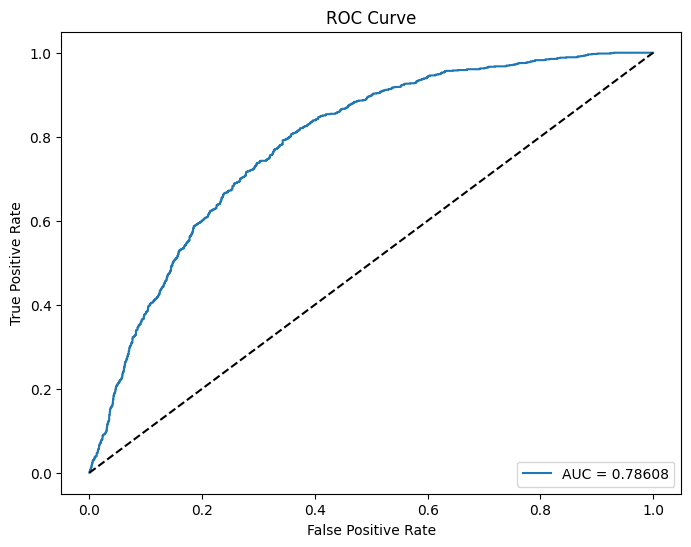

In [206]:
LR_model = LogisticRegression(max_iter=1000)
evaluate_model(LR_model, X_train, X_test, Y_train, Y_test)

### Random Forest

Accuracy: 0.72077
Recall: 0.46660

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6110     0.0        1.0                   0.52
4393     0.0        0.0                   0.00
4002     0.0        0.0                   0.44
8709     0.0        1.0                   0.60
5444     1.0        1.0                   0.63
1330     1.0        0.0                   0.33
6107     1.0        0.0                   0.45
6378     0.0        0.0                   0.43
6929     0.0        0.0                   0.45
6412     0.0        1.0                   0.61
3033     1.0        0.0                   0.50
960      1.0        1.0                   0.64
8770     1.0        1.0                   0.64
315      0.0        0.0                   0.12
7308     1.0        1.0                   0.68
6026     0.0        0.0                   0.02
6768     1.0        1.0                   0.54
1954     0.0        0.0                   0.00
2165     1.0        0.0                   0.16
214

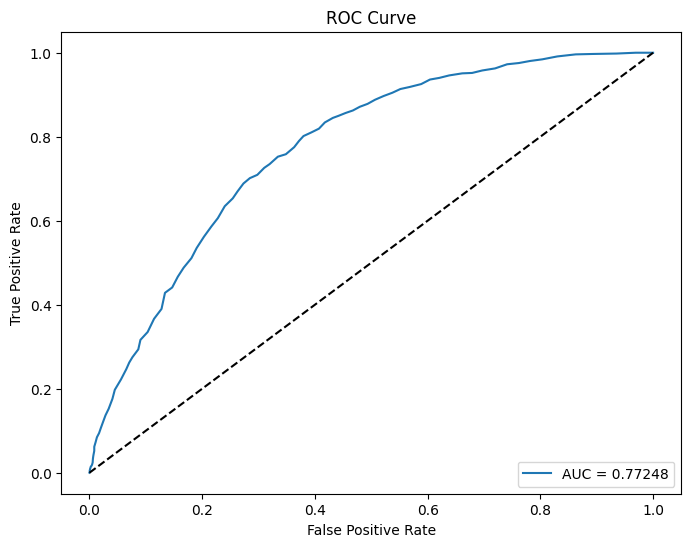

In [207]:
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(RF_model, X_train, X_test, Y_train, Y_test)

Accuracy: 0.72971
Recall: 0.46758

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6110     0.0        1.0               0.552767
4393     0.0        0.0               0.019309
4002     0.0        1.0               0.543196
8709     0.0        1.0               0.532566
5444     1.0        1.0               0.560213
1330     1.0        0.0               0.321762
6107     1.0        0.0               0.395497
6378     0.0        0.0               0.386054
6929     0.0        0.0               0.437026
6412     0.0        1.0               0.634103
3033     1.0        0.0               0.345744
960      1.0        1.0               0.658338
8770     1.0        1.0               0.621952
315      0.0        0.0               0.208136
7308     1.0        1.0               0.586309
6026     0.0        0.0               0.037084
6768     1.0        0.0               0.487966
1954     0.0        0.0               0.020812
2165     1.0        0.0               0.137932
214

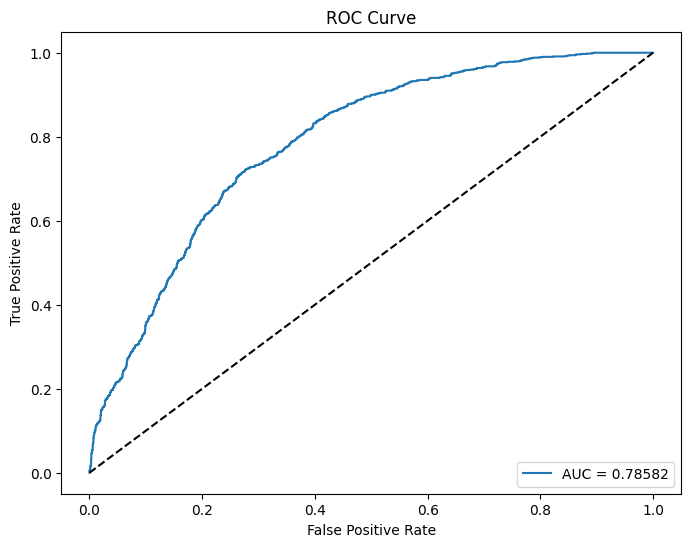

In [208]:
# Define the hyperparameters
rf_params = {
    'n_estimators': 500,
    'min_samples_split': 5,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'max_depth': 10,
    'bootstrap': True
}

# Initialize the Random Forest classifier with the given hyperparameters
rf_model = RandomForestClassifier(**rf_params, random_state=42)

evaluate_model(rf_model, X_train, X_test, Y_train, Y_test)

### Catboost Classifier

Accuracy: 0.73131
Recall: 0.50491

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6110     0.0        1.0               0.628956
4393     0.0        0.0               0.007990
4002     0.0        0.0               0.354728
8709     0.0        0.0               0.447768
5444     1.0        1.0               0.729606
1330     1.0        0.0               0.317453
6107     1.0        0.0               0.283362
6378     0.0        0.0               0.338190
6929     0.0        0.0               0.450940
6412     0.0        1.0               0.560262
3033     1.0        0.0               0.400888
960      1.0        1.0               0.701702
8770     1.0        1.0               0.743048
315      0.0        0.0               0.206459
7308     1.0        1.0               0.799129
6026     0.0        0.0               0.021633
6768     1.0        1.0               0.590850
1954     0.0        0.0               0.020389
2165     1.0        0.0               0.092056
214

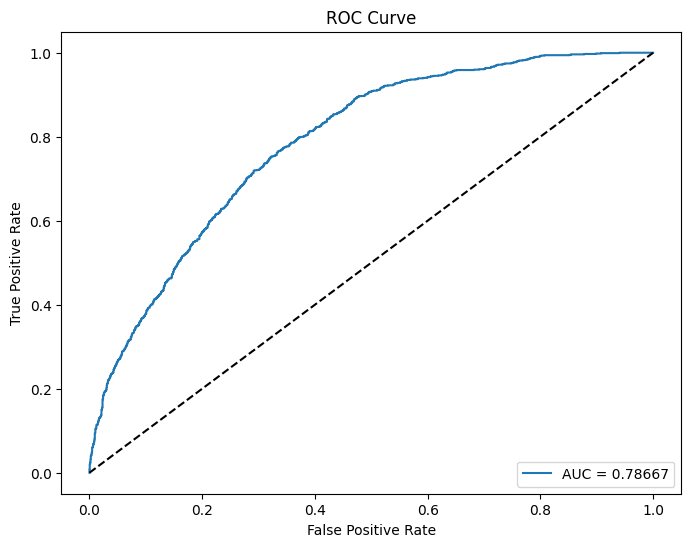

In [209]:
catboost_model = CatBoostClassifier(verbose=0, random_state=42, cat_features=df.select_dtypes(include=['object', 'category']).columns.tolist())
evaluate_model(catboost_model, X_train, X_test, Y_train, Y_test)

### Neural Network 

In [210]:
#{'solver': 'adam', 'nesterovs_momentum': False, 'momentum': 0.95, 'max_iter': 200, 'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (100,), 'early_stopping': True, 'beta_2': 0.9, 'beta_1': 0.8, 'batch_size': 32, 'alpha': 0.01, 'activation': 'logistic'}

c:\Users\larry\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.73450
Recall: 0.44204

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6110     0.0        1.0               0.606883
4393     0.0        0.0               0.008917
4002     0.0        0.0               0.262872
8709     0.0        0.0               0.468799
5444     1.0        1.0               0.607581
1330     1.0        0.0               0.296703
6107     1.0        0.0               0.386797
6378     0.0        0.0               0.313544
6929     0.0        0.0               0.407477
6412     0.0        1.0               0.616346
3033     1.0        0.0               0.314669
960      1.0        1.0               0.695881
8770     1.0        1.0               0.539699
315      0.0        0.0               0.219829
7308     1.0        1.0               0.590470
6026     0.0        0.0               0.027678
6768     1.0        1.0               0.517668
1954     0.0        0.0               0.021460
2165     1.0        0.0               0.119951
214

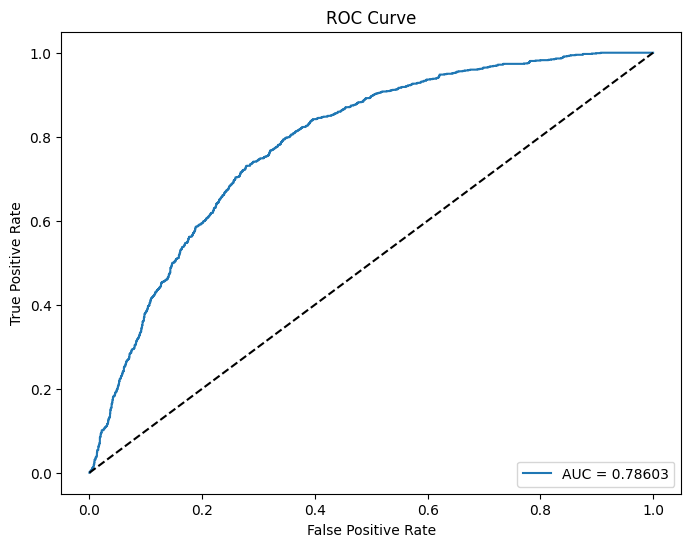

In [211]:
nn_model = MLPClassifier(hidden_layer_sizes=(20,), activation='relu', solver='adam', max_iter=100, random_state=42)
evaluate_model(nn_model, X_train, X_test, Y_train, Y_test)

In [212]:
# # Define the initial neural network model
# nn_model = MLPClassifier(random_state=42)

# # Define a more extensive parameter grid for random search
# param_distributions = {
#     'hidden_layer_sizes': [ (20,), (50,), (100,), (150,), (50, 50), (100, 50), (100, 100),],  # More layer combinations
#     'activation': ['tanh', 'logistic', 'identity'],  # Different activation functions
#     'solver': ['adam', 'sgd'],  # Solvers for weight optimization
#     'alpha': np.logspace(-5, -1, 5),  # L2 penalty (regularization) term
#     'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Learning rate schedules
#     'learning_rate_init': np.logspace(-4, -1, 4),  # Initial learning rate
#     'max_iter': [100, 200, 300],  # Number of epochs
#     'batch_size': [16, 32],  # Size of minibatches
#     'momentum': [0.9, 0.95],  # Momentum for SGD solver
#     'nesterovs_momentum': [True, False],  # Whether to use Nesterov's momentum
#     'early_stopping': [True, False],  # Whether to use early stopping to terminate training
#     'beta_1': [0.8, 0.9],  # Exponential decay rate for estimates of first moment vector in adam
#     'beta_2': [0.9, 0.99],  # Exponential decay rate for estimates of second moment vector in adam
# }

# # Set up the RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=nn_model,
#     param_distributions=param_distributions,
#     n_iter=70,  # Number of parameter settings sampled
#     scoring='roc_auc',  # Scoring metric to use
#     n_jobs=-1,  # Use all available cores
#     cv=5,  # 5-fold cross-validation
#     verbose=3,  # Verbosity level
#     random_state=42  # Random state for reproducibility
# )

# # Assuming your data is already prepared in X_train and Y_train
# # Perform the random search
# random_search.fit(X_train, Y_train)

# # Print the best parameters and the best score from the random search
# print("Best parameters found by random search:")
# print(random_search.best_params_)

# print("\nBest AUC score from random search:")
# print(f"{random_search.best_score_:.5f}")

# # Optionally, evaluate the best model using your evaluation function
# best_nn_model = random_search.best_estimator_
# evaluate_model(best_nn_model, X_train, X_test, Y_train, Y_test)

## Feature Selection

In [213]:
def show_important_features(model_used):
    feature_names = X_train.keys()
    # Assuming feature_names is a list of feature names in the order they were used to train the model
    scores = model_used.feature_importances_
    
    # Sorting the features by their importance
    indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    sorted_feature_names = [feature_names[i] for i in indices]
    sorted_scores = [scores[i] for i in indices]
    
    # Creating the horizontal bar chart
    plt.figure(figsize=(5, 6))
    plt.barh(sorted_feature_names, sorted_scores)
    plt.xlabel('Importance')
    plt.title('Feature Importances')
    plt.show()
    
    return sorted_feature_names

In [214]:
# Creates an empty array to be populated
included_features_model = [[None] * 35 for _ in range(4)]

# Convert data to numpy arrays
X = np.asarray(X_train, dtype=np.float32)
Y = np.asarray(Y_train, dtype=np.float32)

In [215]:
def evaluate_features_with_rfe(model):
    # Define RFECV selector with StratifiedKFold cross-validation
    selector = RFE(model)

    # Fit RFECV selector to the data
    selector = selector.fit(X, Y)

    # Get the included features from the selector
    included_features = selector.support_

    # Update the included features for CatBoost model
    included_features_model[2] = included_features

    # Fit CatBoost model with the training data
    model.fit(X_train, Y_train)

    # Get important features from the trained CatBoost model
    droped = show_important_features(model)

### Random Forest

In [216]:
# evaluate_features_with_rfe(rf_model)

In [217]:
X_train_rfdropped = X_train.drop(columns=[ 'Smoker', 'SaltFreq', 'AlcConsump/Yr'])
X_test_rfdropped = X_test.drop(columns=[ 'Smoker', 'SaltFreq', 'AlcConsump/Yr'])

Accuracy: 0.73099
Recall: 0.47348

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6110     0.0        1.0               0.550865
4393     0.0        0.0               0.020157
4002     0.0        0.0               0.491996
8709     0.0        1.0               0.562464
5444     1.0        1.0               0.567134
1330     1.0        0.0               0.351408
6107     1.0        0.0               0.391167
6378     0.0        0.0               0.359355
6929     0.0        0.0               0.423677
6412     0.0        1.0               0.641897
3033     1.0        0.0               0.332166
960      1.0        1.0               0.659112
8770     1.0        1.0               0.602839
315      0.0        0.0               0.211027
7308     1.0        1.0               0.570797
6026     0.0        0.0               0.029070
6768     1.0        1.0               0.527501
1954     0.0        0.0               0.021766
2165     1.0        0.0               0.132392
214

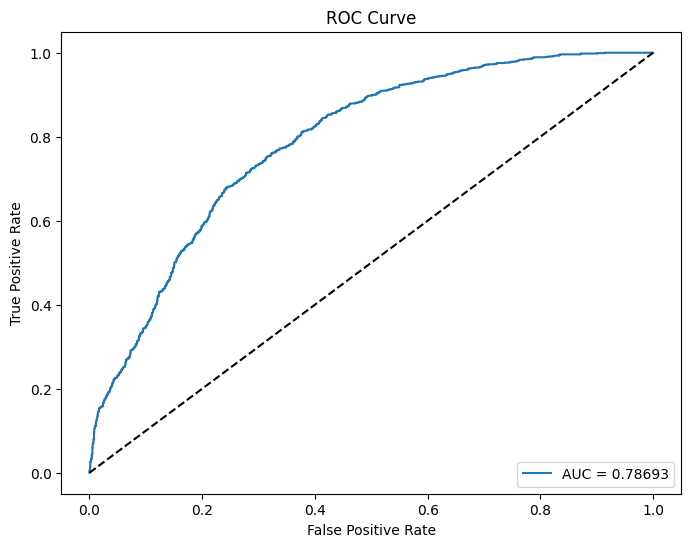

In [218]:
evaluate_model(rf_model, X_train_rfdropped, X_test_rfdropped, Y_train, Y_test)

In [219]:
test_rfdropped = df_scaled_testing.drop(columns=[ 'Smoker', 'SaltFreq', 'AlcConsump/Yr'])

### Catboost

In [220]:
# evaluate_features_with_rfe(catboost_model)

In [221]:
X_train_catdropped = X_train.drop(columns=['Smoker', 'AlcConsumpFreq','SaltFreq'])
X_test_catdropped = X_test.drop(columns=['Smoker', 'AlcConsumpFreq', 'SaltFreq'])

Accuracy: 0.73035
Recall: 0.49509

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6110     0.0        1.0               0.554168
4393     0.0        0.0               0.009107
4002     0.0        0.0               0.403108
8709     0.0        0.0               0.490299
5444     1.0        1.0               0.743956
1330     1.0        0.0               0.256977
6107     1.0        0.0               0.288559
6378     0.0        0.0               0.330103
6929     0.0        0.0               0.454926
6412     0.0        0.0               0.497607
3033     1.0        0.0               0.370446
960      1.0        1.0               0.582801
8770     1.0        1.0               0.695309
315      0.0        0.0               0.204329
7308     1.0        1.0               0.705002
6026     0.0        0.0               0.024464
6768     1.0        1.0               0.510501
1954     0.0        0.0               0.020004
2165     1.0        0.0               0.085348
214

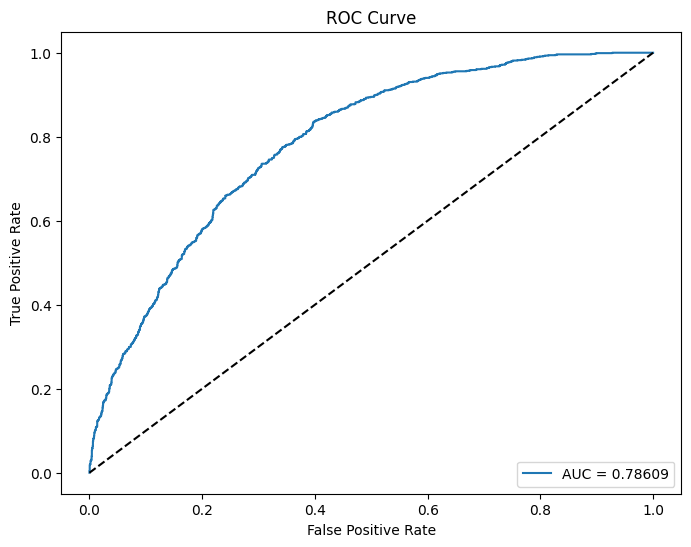

In [222]:
evaluate_model(catboost_model, X_train_catdropped, X_test_catdropped, Y_train, Y_test)

In [223]:
test_catdropped = df_scaled_testing.drop(columns=['Smoker', 'AlcConsumpFreq', 'SaltFreq'])

### Logistic Regression and Neural Networks

Logistic Regression and Neural Networks do not support RFE. Hence the commonly dropped features between Random Forest and Catboost are dropped 

In [224]:
X_train_remdropped = X_train.drop(columns=['Smoker', 'SaltFreq'])
X_test_remdropped = X_test.drop(columns=['Smoker', 'SaltFreq'])
test_rem = df_scaled_testing.drop(columns=['Smoker', 'SaltFreq'])

Accuracy: 0.73546
Recall: 0.47446

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6110     0.0        1.0               0.636207
4393     0.0        0.0               0.029458
4002     0.0        0.0               0.328881
8709     0.0        0.0               0.450177
5444     1.0        1.0               0.658210
1330     1.0        0.0               0.291516
6107     1.0        0.0               0.355515
6378     0.0        0.0               0.300246
6929     0.0        0.0               0.442730
6412     0.0        1.0               0.687004
3033     1.0        0.0               0.304645
960      1.0        1.0               0.829752
8770     1.0        1.0               0.685059
315      0.0        0.0               0.218759
7308     1.0        1.0               0.643655
6026     0.0        0.0               0.065608
6768     1.0        1.0               0.578497
1954     0.0        0.0               0.049910
2165     1.0        0.0               0.109815
214

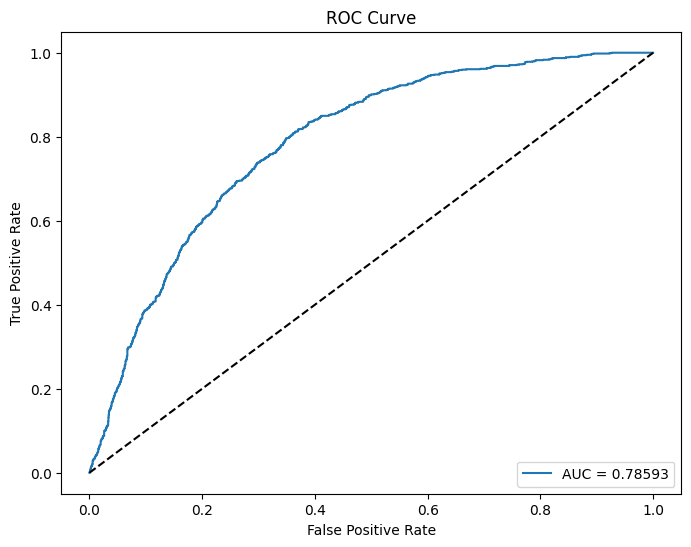

In [225]:
evaluate_model(LR_model, X_train_remdropped, X_test_remdropped, Y_train, Y_test)

c:\Users\larry\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.73419
Recall: 0.49411

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6110     0.0        1.0               0.597344
4393     0.0        0.0               0.008647
4002     0.0        0.0               0.300341
8709     0.0        1.0               0.555353
5444     1.0        1.0               0.626466
1330     1.0        0.0               0.325391
6107     1.0        0.0               0.397125
6378     0.0        0.0               0.315286
6929     0.0        0.0               0.469316
6412     0.0        1.0               0.661211
3033     1.0        0.0               0.240989
960      1.0        1.0               0.755421
8770     1.0        1.0               0.694261
315      0.0        0.0               0.237925
7308     1.0        1.0               0.583961
6026     0.0        0.0               0.028002
6768     1.0        0.0               0.484417
1954     0.0        0.0               0.021886
2165     1.0        0.0               0.156575
214

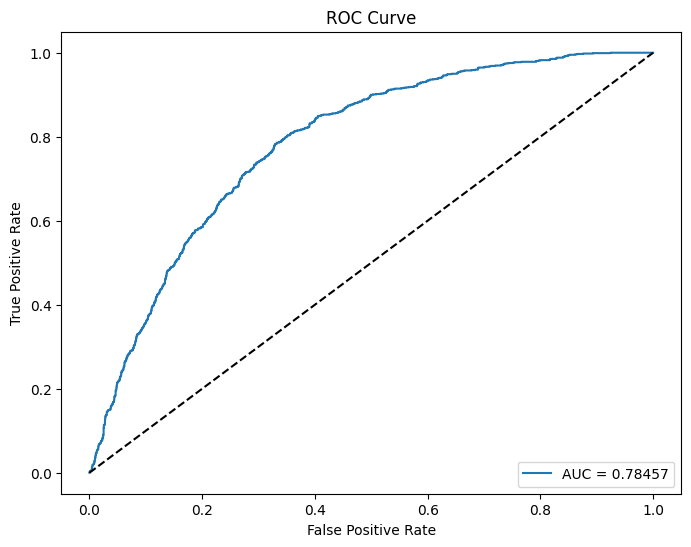

In [226]:
evaluate_model(nn_model, X_train_remdropped, X_test_remdropped, Y_train, Y_test)

### Hyperparameter Tuning

In [227]:
# # Initialize the RandomForestClassifier
# random_forest_model = RandomForestClassifier(random_state=42)

# # Define the parameter grid for random search
# param_distributions = {
#     'n_estimators': [100, 500, 1000, 1500],  # Number of trees in the forest
#     'max_features': ['sqrt', 'log2', None],       # Number of features to consider at each split
#     'max_depth': [None, 10, 30, 50],              # Maximum number of levels in each decision tree
#     'min_samples_split': [2, 5, 10],              # Minimum number of samples required to split a node
#     'min_samples_leaf': [1, 2, 4],                # Minimum number of samples required at each leaf node
#     'bootstrap': [True, False]                    # Method for sampling data points (with or without replacement)
# }

# # Define the RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=random_forest_model,
#     param_distributions=param_distributions,
#     n_iter=80,              # Number of parameter settings sampled
#     scoring='roc_auc',      # Scoring metric to use
#     n_jobs=-1,              # Use all available cores
#     cv=3,                   # 3-fold cross-validation (was previously 5 in the comments)
#     verbose=3,              # Verbosity level
#     random_state=42
# )

# # Perform the random search
# random_search.fit(X_train_rfdropped, Y_train)

# # Print the best parameters and the best score from the random search
# print("Best parameters found by random search:")
# print(random_search.best_params_)

# print("\nBest AUC score from random search:")
# print(f"{random_search.best_score_:.5f}")

# best_rf_model = random_search.best_estimator_
# evaluate_model(best_rf_model, X_train_rfdropped, X_test_rfdropped, Y_train, Y_test)

In [228]:
# # Initialize CatBoostClassifier
# catboost_model = CatBoostClassifier(verbose=0, random_state=42, cat_features=df.select_dtypes(include=['object', 'category']).columns.tolist())

# # Define the hyperparameter grid
# param_grid = {
#     'iterations': [100, 300, 500],
#     'depth': [4, 6, 8],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'l2_leaf_reg': [1, 3, 5, 7],
#     'border_count': [32, 64, 128]
# }

# # Set up GridSearchCV
# grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# # Fit GridSearchCV
# grid_search.fit(X_train, Y_train)

# # Get the best model from grid search
# best_catboost_model = grid_search.best_estimator_

# # Train the model with the best parameters
# best_catboost_model.fit(X_train, Y_train)

# # Evaluate the best model using the provided evaluate_model function
# evaluate_model(best_catboost_model, X_train, X_test, Y_train, Y_test)

# # Output best parameters
# print("Best parameters found: ", grid_search.best_params_)

In [229]:
# #'scale_pos_weight': 1, 'random_strength': 1.0, 'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 500, 'depth': 3, 'border_count': 128, 'bagging_temperature': 0.0}
# # Initialize CatBoostClassifier
# catboost_model = CatBoostClassifier(verbose=0, random_state=42, cat_features=df.select_dtypes(include=['object', 'category']).columns.tolist())

# # Define the hyperparameter grid
# param_grid = {
#     'iterations': [100, 200, 300],
#     'depth': [4, 6, 8],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'l2_leaf_reg': [1, 3, 5, 7],
#     'border_count': [32, 64, 128]
# }

# # Set up GridSearchCV
# # grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# # Fit GridSearchCV
# # grid_search.fit(X_train, Y_train)

# # Get the best model from grid search
# # best_catboost_model = grid_search.best_estimator_

# # Manually set the best parameters
# best_params = {'border_count': 128, 'depth': 3, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.01}
# best_catboost_model = CatBoostClassifier(verbose=0, random_state=42, cat_features=df.select_dtypes(include=['object', 'category']).columns.tolist(), **best_params)

# # Train the model with the best parameters
# best_catboost_model.fit(X_train_catdropped, Y_train)

# # Evaluate the best model using the provided evaluate_model function
# evaluate_model(best_catboost_model, X_train_catdropped, X_test_catdropped, Y_train, Y_test)

# # Output best parameters
# print("Best parameters found: ",best_params)

In [230]:
# # Define the initial neural network model
# nn_model = MLPClassifier(random_state=42)

# # Define a more extensive parameter grid for random search
# param_distributions = {
#     'hidden_layer_sizes': [ (20,), (50,), (100,), (150,), (50, 50), (100, 50), (100, 100), (150, 100)],  # More layer combinations
#     'activation': ['relu', 'tanh', 'logistic', 'identity'],  # Different activation functions
#     'solver': ['adam', 'sgd', 'lbfgs'],  # Solvers for weight optimization
#     'alpha': np.logspace(-5, -1, 5),  # L2 penalty (regularization) term
#     'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Learning rate schedules
#     'learning_rate_init': np.logspace(-4, -1, 4),  # Initial learning rate
#     'max_iter': [200, 350, 500],  # Number of epochs
#     'batch_size': [32, 64, 128, 256],  # Size of minibatches
#     'momentum': [0.9, 0.95, 0.99],  # Momentum for SGD solver
#     'nesterovs_momentum': [True, False],  # Whether to use Nesterov's momentum
#     'early_stopping': [True, False],  # Whether to use early stopping to terminate training
#     'beta_1': [0.8, 0.9, 0.99],  # Exponential decay rate for estimates of first moment vector in adam
#     'beta_2': [0.9, 0.99, 0.999],  # Exponential decay rate for estimates of second moment vector in adam
# }

# # Set up the RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=nn_model,
#     param_distributions=param_distributions,
#     n_iter=80,  # Number of parameter settings sampled
#     scoring='roc_auc',  # Scoring metric to use
#     n_jobs=-1,  # Use all available cores
#     cv=3,  # 5-fold cross-validation
#     verbose=3,  # Verbosity level
#     random_state=42  # Random state for reproducibility
# )

# # Assuming your data is already prepared in X_train and Y_train
# # Perform the random search
# random_search.fit(X_train_remdropped, Y_train)

# # Print the best parameters and the best score from the random search
# print("Best parameters found by random search:")
# print(random_search.best_params_)

# print("\nBest AUC score from random search:")
# print(f"{random_search.best_score_:.5f}")

# # Optionally, evaluate the best model using your evaluation function
# best_nn_model = random_search.best_estimator_
# evaluate_model(best_nn_model, X_train_remdropped, X_test_remdropped, Y_train, Y_test)

## Tuned Models

In [231]:
best_rf_model = RandomForestClassifier(
    n_estimators=100,    # Number of trees
    max_depth=10,        # Maximum depth of each tree
    min_samples_split=2, # Minimum number of samples required to split an internal node
    min_samples_leaf=1,  # Minimum number of samples required to be at a leaf node
    random_state=42      # Ensures reproducibility
)

Accuracy: 0.72556
Recall: 0.47151

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6110     0.0        1.0               0.533945
4393     0.0        0.0               0.023022
4002     0.0        0.0               0.460211
8709     0.0        1.0               0.607285
5444     1.0        1.0               0.573587
1330     1.0        0.0               0.306194
6107     1.0        0.0               0.439259
6378     0.0        0.0               0.409004
6929     0.0        0.0               0.427277
6412     0.0        1.0               0.632768
3033     1.0        0.0               0.363696
960      1.0        1.0               0.682472
8770     1.0        1.0               0.669015
315      0.0        0.0               0.206037
7308     1.0        1.0               0.548147
6026     0.0        0.0               0.031536
6768     1.0        1.0               0.546265
1954     0.0        0.0               0.024263
2165     1.0        0.0               0.133720
214

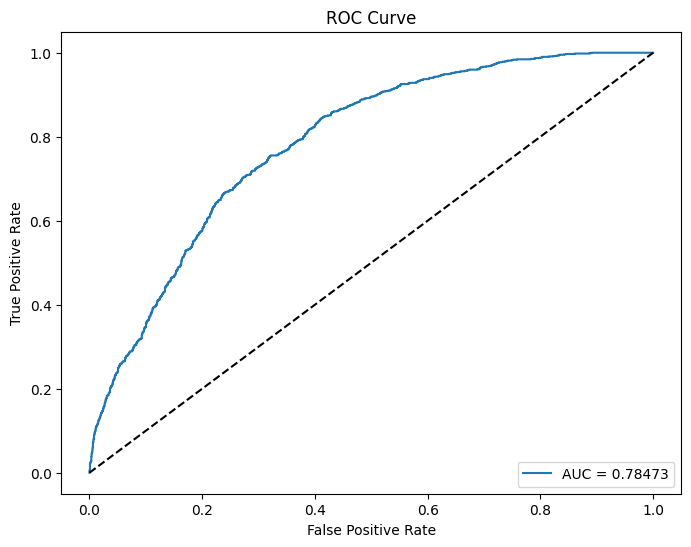

In [232]:
evaluate_model(best_rf_model, X_train_rfdropped, X_test_rfdropped, Y_train, Y_test)

In [233]:
best_catboost_model = CatBoostClassifier(
    border_count=128,
    depth=3,
    iterations=500,
    l2_leaf_reg=5,
    learning_rate=0.01,
    verbose=False  # set to True to see training logs
)

Accuracy: 0.73387
Recall: 0.50786

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6110     0.0        1.0               0.607254
4393     0.0        0.0               0.045374
4002     0.0        0.0               0.445452
8709     0.0        1.0               0.523653
5444     1.0        1.0               0.582679
1330     1.0        0.0               0.369437
6107     1.0        0.0               0.395378
6378     0.0        0.0               0.369726
6929     0.0        0.0               0.493328
6412     0.0        1.0               0.666424
3033     1.0        0.0               0.249150
960      1.0        1.0               0.628215
8770     1.0        1.0               0.605892
315      0.0        0.0               0.194534
7308     1.0        1.0               0.576268
6026     0.0        0.0               0.062655
6768     1.0        1.0               0.529185
1954     0.0        0.0               0.048586
2165     1.0        0.0               0.145211
214

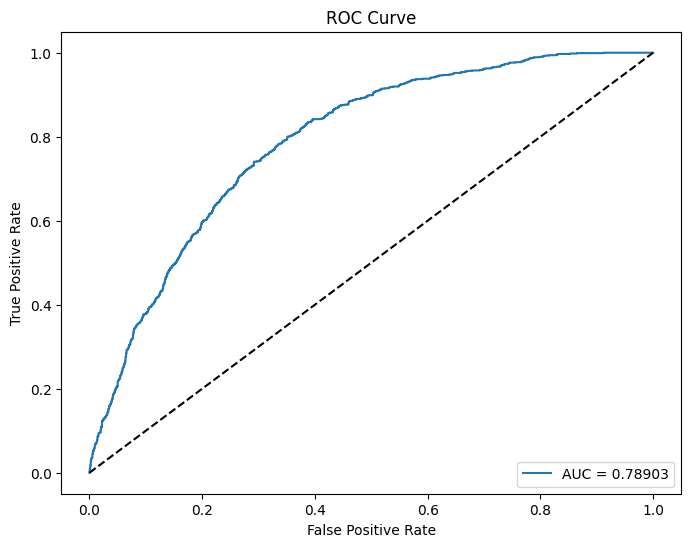

In [234]:
evaluate_model(best_catboost_model, X_train_catdropped, X_test_catdropped, Y_train, Y_test)

In [235]:
best_nn_model = MLPClassifier(
    solver='sgd',
    nesterovs_momentum=False,
    momentum=0.9,
    max_iter=350,
    learning_rate_init=0.01,
    learning_rate='constant',
    hidden_layer_sizes=(50,),
    early_stopping=False,
    beta_2=0.99,
    beta_1=0.8,
    batch_size=32,
    alpha=0.01,
    activation='relu',
    random_state=42
)

Accuracy: 0.73099
Recall: 0.48527

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6110     0.0        1.0               0.621507
4393     0.0        0.0               0.011306
4002     0.0        0.0               0.382409
8709     0.0        1.0               0.517870
5444     1.0        1.0               0.500029
1330     1.0        0.0               0.220870
6107     1.0        0.0               0.364999
6378     0.0        0.0               0.292090
6929     0.0        0.0               0.431735
6412     0.0        1.0               0.634383
3033     1.0        0.0               0.299959
960      1.0        1.0               0.713416
8770     1.0        1.0               0.689736
315      0.0        0.0               0.150289
7308     1.0        1.0               0.505231
6026     0.0        0.0               0.025940
6768     1.0        1.0               0.501755
1954     0.0        0.0               0.021789
2165     1.0        0.0               0.086708
214

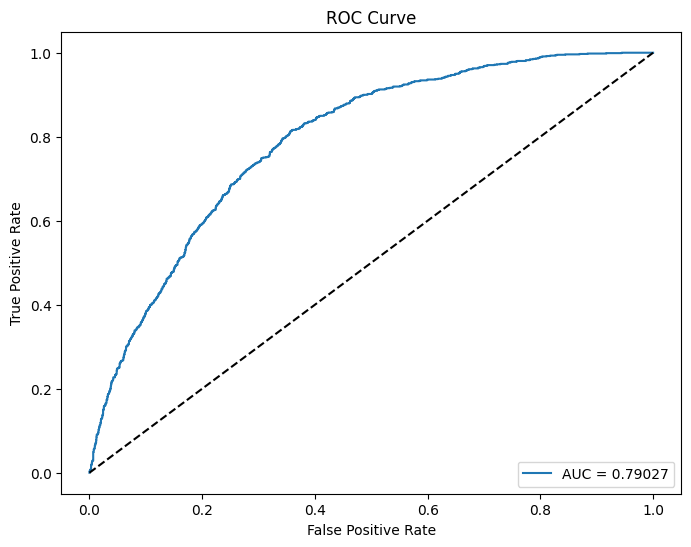

In [236]:
evaluate_model(best_nn_model, X_train_remdropped, X_test_remdropped, Y_train, Y_test)

## External Data Test

In [237]:
# Predict probabilities on df_scaled_11_12
pred_prob = LR_model.predict_proba(test_rem)[:, 1]

# Predict classes on df_scaled_11_12
pred_class = LR_model.predict(test_rem)

# Calculate accuracy
accuracy = accuracy_score(target_15_16, pred_class)

# Calculate AUC score
auc_score = roc_auc_score(target_15_16, pred_prob)

# Create a DataFrame with prediction probability, actual result, and predicted result
results_df = pd.DataFrame({
    'Prediction Probability': pred_prob,
    'Actual Result': target_15_16,
    'Predicted Result': pred_class
})

# Output the results
print("Accuracy: ", accuracy)
print("AUC Score: ", auc_score)
print("Results DataFrame:")
print(results_df.to_string())

Accuracy:  0.7519493177387915
AUC Score:  0.7812719825990374
Results DataFrame:
      Prediction Probability  Actual Result  Predicted Result
0                   0.059659            0.0               0.0
1                   0.048663            0.0               0.0
2                   0.044388            0.0               0.0
3                   0.281580            0.0               0.0
4                   0.090768            0.0               0.0
5                   0.107081            0.0               0.0
6                   0.174137            1.0               0.0
7                   0.085878            0.0               0.0
8                   0.445655            1.0               0.0
9                   0.637747            1.0               1.0
10                  0.231985            1.0               0.0
11                  0.126565            0.0               0.0
12                  0.294162            1.0               0.0
13                  0.245426            0.0         

In [238]:
# Predict probabilities on df_scaled_11_12
pred_prob = best_rf_model.predict_proba(test_rfdropped)[:, 1]

# Predict classes on df_scaled_11_12
pred_class = best_rf_model.predict(test_rfdropped)

# Calculate accuracy
accuracy = accuracy_score(target_15_16, pred_class)

# Calculate AUC score
auc_score = roc_auc_score(target_15_16, pred_prob)

# Create a DataFrame with prediction probability, actual result, and predicted result
results_df = pd.DataFrame({
    'Prediction Probability': pred_prob,
    'Actual Result': target_15_16,
    'Predicted Result': pred_class
})

# Output the results
print("Accuracy: ", accuracy)
print("AUC Score: ", auc_score)
print("Results DataFrame:")
print(results_df.to_string())

Accuracy:  0.746588693957115
AUC Score:  0.7760597926693817
Results DataFrame:
      Prediction Probability  Actual Result  Predicted Result
0                   0.178051            0.0               0.0
1                   0.173801            0.0               0.0
2                   0.113250            0.0               0.0
3                   0.261233            0.0               0.0
4                   0.177293            0.0               0.0
5                   0.131873            0.0               0.0
6                   0.350578            1.0               0.0
7                   0.221540            0.0               0.0
8                   0.655466            1.0               1.0
9                   0.667123            1.0               1.0
10                  0.315128            1.0               0.0
11                  0.329091            0.0               0.0
12                  0.475246            1.0               0.0
13                  0.405051            0.0          

In [239]:
# Predict probabilities on df_scaled_11_12
pred_prob = best_catboost_model.predict_proba(test_catdropped)[:, 1]

# Predict classes on df_scaled_11_12
pred_class = best_catboost_model.predict(test_catdropped)

# Calculate accuracy
accuracy = accuracy_score(target_15_16, pred_class)

# Calculate AUC score
auc_score = roc_auc_score(target_15_16, pred_prob)

# Create a DataFrame with prediction probability, actual result, and predicted result
results_df = pd.DataFrame({
    'Prediction Probability': pred_prob,
    'Actual Result': target_15_16,
    'Predicted Result': pred_class
})

# Output the results
print("Accuracy: ", accuracy)
print("AUC Score: ", auc_score)
print("Results DataFrame:")
print(results_df.to_string())

Accuracy:  0.7504873294346979
AUC Score:  0.7894495094409478
Results DataFrame:
      Prediction Probability  Actual Result  Predicted Result
0                   0.110559            0.0               0.0
1                   0.098754            0.0               0.0
2                   0.058934            0.0               0.0
3                   0.312546            0.0               0.0
4                   0.114277            0.0               0.0
5                   0.083132            0.0               0.0
6                   0.202112            1.0               0.0
7                   0.137379            0.0               0.0
8                   0.553927            1.0               1.0
9                   0.626226            1.0               1.0
10                  0.253289            1.0               0.0
11                  0.196789            0.0               0.0
12                  0.290204            1.0               0.0
13                  0.349966            0.0         

In [240]:
# Predict probabilities on df_scaled_11_12
pred_prob = best_nn_model.predict_proba(test_rem)[:, 1]

# Predict classes on df_scaled_11_12
pred_class = best_nn_model.predict(test_rem)

# Calculate accuracy
accuracy = accuracy_score(target_15_16, pred_class)

# Calculate AUC score
auc_score = roc_auc_score(target_15_16, pred_prob)

# Create a DataFrame with prediction probability, actual result, and predicted result
results_df = pd.DataFrame({
    'Prediction Probability': pred_prob,
    'Actual Result': target_15_16,
    'Predicted Result': pred_class
})

# Output the results
print("Accuracy: ", accuracy)
print("AUC Score: ", auc_score)
print("Results DataFrame:")
print(results_df.to_string())

Accuracy:  0.7426900584795322
AUC Score:  0.7815311458718993
Results DataFrame:
      Prediction Probability  Actual Result  Predicted Result
0                   0.088467            0.0               0.0
1                   0.060965            0.0               0.0
2                   0.033816            0.0               0.0
3                   0.252114            0.0               0.0
4                   0.084090            0.0               0.0
5                   0.109335            0.0               0.0
6                   0.358989            1.0               0.0
7                   0.113370            0.0               0.0
8                   0.602280            1.0               1.0
9                   0.600677            1.0               1.0
10                  0.331058            1.0               0.0
11                  0.250638            0.0               0.0
12                  0.414575            1.0               0.0
13                  0.307586            0.0         

## Saving Best Model

In [244]:
# Save the model to a .cbm file
best_catboost_model.save_model('model.cbm', format='cbm')

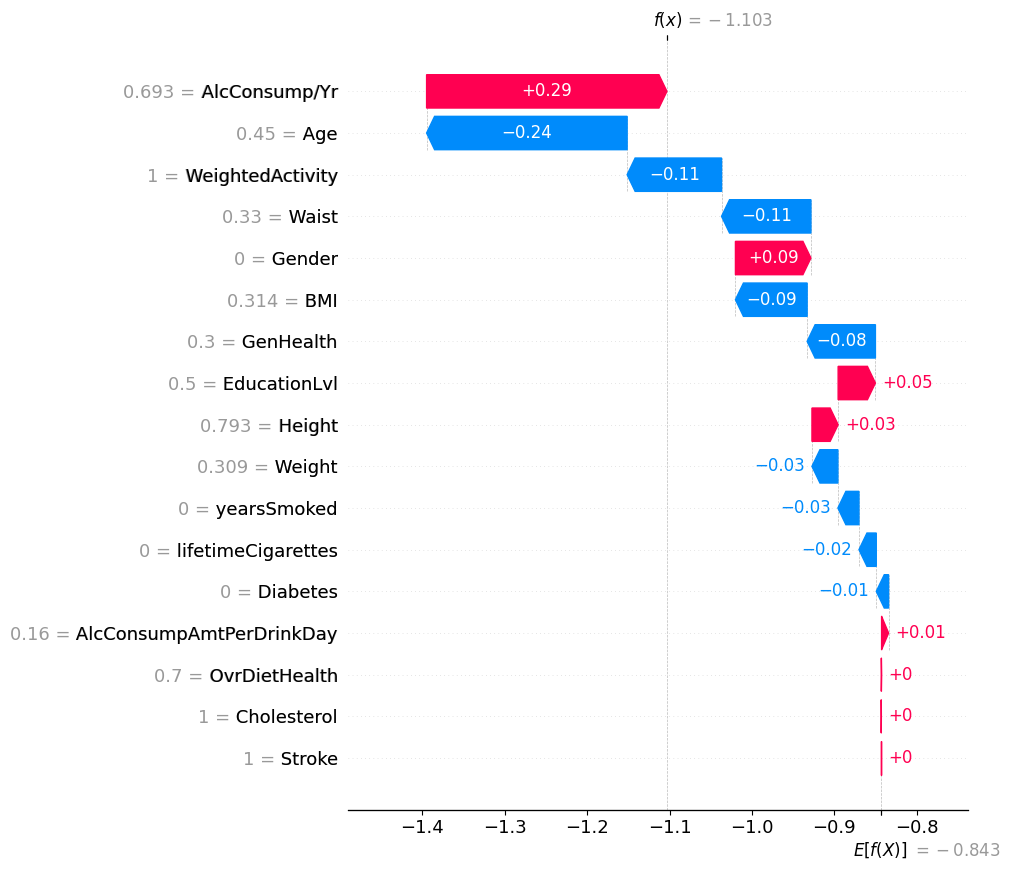

In [241]:
instance = X_test_catdropped.iloc[[10]]
# Create a SHAP explainer
explainer = shap.Explainer(best_catboost_model, X_train_catdropped)

# Calculate SHAP values for the test set
shap_values = explainer(instance)

# Visualize the SHAP values
# shap.summary_plot(shap_values, instance)
# Adjust max_display to show all features
shap.plots.waterfall(shap_values[0], max_display=20)  # Set max_display to None or a large number


In [242]:
with open('shap_explainer.pkl', 'wb') as f:
    pickle.dump(explainer, f)

In [243]:
masker = shap.maskers.Independent(data=X_train_catdropped)

def catboost_predict_proba(data):
    return best_catboost_model.predict_proba(data)[:, 1]

explainer = shap.Explainer(catboost_predict_proba, masker)
shap_values = explainer(X_train_catdropped)

shap.plots.bar(shap_values)


PermutationExplainer explainer:  20%|█▉        | 1139/5811 [01:45<07:55,  9.83it/s]


KeyboardInterrupt: 

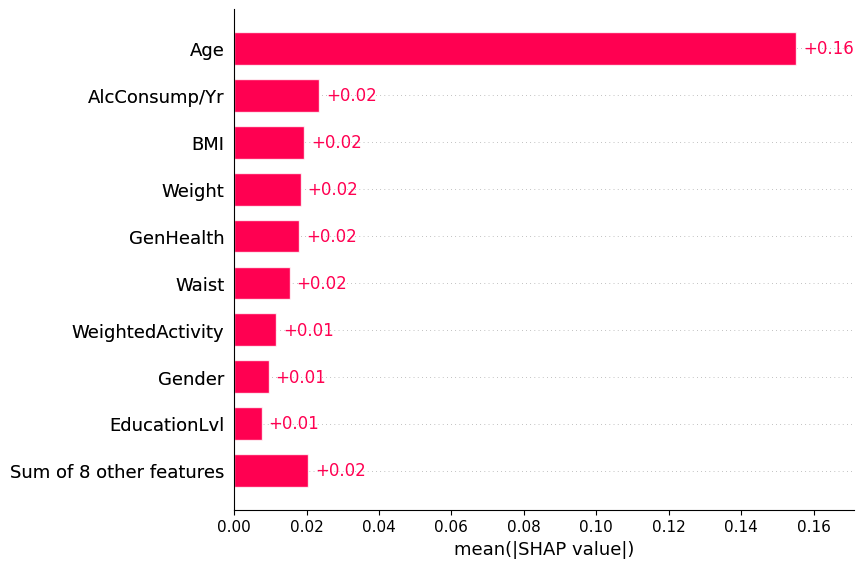

In [96]:
shap.plots.bar(shap_values)